## Finding Monthly Title Cell

# Athabasca Glacier Albedo Analysis

## Introduction and Methodology

This analysis compares MODIS satellite-derived albedo measurements with ground-truth automatic weather station (AWS) observations for glacier surface albedo validation. The study employs multiple MODIS products and temporal aggregation approaches to assess the accuracy and reliability of satellite-based albedo retrievals.

### Study Objectives

1. **Evaluate MODIS albedo products** against high-quality ground measurements
2. **Compare different MODIS methods** (MCD43A3 BRDF, MOD09GA surface reflectance, MOD10A1 snow product)
3. **Assess Terra/Aqua data fusion** effectiveness for improved temporal coverage
4. **Analyze temporal patterns** across multiple timescales (daily, weekly, 16-day, monthly)
5. **Identify optimal approaches** for glacier albedo monitoring

### Data Processing Methodology

- **Terra/Aqua Fusion**: Combined Terra and Aqua observations using mean values when both satellites provide data, or single observations when only one is available
- **Temporal Aggregation**: Analysis at multiple scales from daily observations to monthly composites
- **Quality Control**: Systematic outlier detection and statistical validation
- **Spatial Analysis**: Pixel-level comparisons and geographic context evaluation

The following sections present comprehensive statistical comparisons, temporal pattern analysis, and method performance evaluation across different aggregation periods.

## Core & Spatial Library Imports

#### Import and load libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Optional spatial libraries
try:
    import geopandas as gpd
    import contextily as ctx
    from shapely.geometry import Point
    SPATIAL_LIBS = True
    print("Spatial libraries available")
except ImportError:
    SPATIAL_LIBS = False
    print("Warning: Spatial libraries not available. Install geopandas and contextily for spatial analysis.")

Spatial libraries available



#### Glacier Data Catalog and Loader Functions

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# GLACIER CATALOG & LOADING FUNCTIONS
# ──────────────────────────────────────────────────────────────────────────────
from pathlib import Path

# Glacier data catalog - add new glaciers here
CATALOG = {
    "athabasca": {
        "modis_csv": "data/csv/Athabasca_Terra_Aqua_MultiProduct_2014-01-01_to_2021-01-01.csv",
        "aws_csv":   "data/csv/iceAWS_Atha_albedo_daily_20152020_filled_clean.csv",
        "mask_shp":  "data/mask/masque_athabasa_zone_ablation.shp",
        "aws_pts":   "data/mask/Point_Custom.shp",
    },
    "haig": {
        "modis_csv": "data/csv/Haig_Terra_Aqua_MultiProduct_2014-01-01_to_2021-01-01.csv",
        "aws_csv":   "data/csv/iceAWS_Haig_albedo_daily_20152020_filled_clean.csv",
        "mask_shp":  "data/mask/haig_mask.shp",
        "aws_pts":   "data/mask/haig_aws.shp",
    },
}

def load_glacier(name="athabasca"):
    """Load all data files for the specified glacier"""
    if name not in CATALOG:
        raise ValueError(f"Unknown glacier: {name}. Options: {list(CATALOG)}")
    
    cfg = CATALOG[name]
    modis_df = pd.read_csv(cfg["modis_csv"])
    aws_df   = pd.read_csv(cfg["aws_csv"])
    
    # Load spatial data if available
    if SPATIAL_LIBS:
        try:
            mask_gdf = gpd.read_file(cfg["mask_shp"]) if Path(cfg["mask_shp"]).exists() else None
            aws_gdf  = gpd.read_file(cfg["aws_pts"]) if Path(cfg["aws_pts"]).exists() else None
        except Exception as e:
            print(f"Warning: Could not load spatial data: {e}")
            mask_gdf, aws_gdf = None, None
    else:
        mask_gdf, aws_gdf = None, None
    
    return modis_df, aws_df, mask_gdf, aws_gdf

print(f"✓ Glacier catalog initialized with {len(CATALOG)} glaciers: {list(CATALOG.keys())}")

✓ Glacier catalog initialized with 2 glaciers: ['athabasca', 'haig']
📁 All plots and reports will be saved to: D:\Documents\Projects\athabasca_analysis\exports


#### Export Directory Setup

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# EXPORT FOLDER & FILE-NAME HELPER
# ──────────────────────────────────────────────────────────────────────────────

# Create exports directory for organized output
EXPORT_DIR = Path("exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

def out(filename: str) -> str:
    """Return a glacier-prefixed path inside exports/ directory"""
    return str(EXPORT_DIR / f"{GLACIER}_{filename}")

print(f"📁 All plots and reports will be saved to: {EXPORT_DIR.resolve()}")

#### Glacier Selection and Data Loading

In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# GLACIER SELECTION & DATA LOADING
# ──────────────────────────────────────────────────────────────────────────────

# ────────────────────────────────────────────────────────────────────────────
# SELECT GLACIER HERE (change to "haig" when needed)
GLACIER = "athabasca"
# ────────────────────────────────────────────────────────────────────────────

# Optional: Interactive widget selector (uncomment if needed)
# try:
#     import ipywidgets as wd
#     from IPython.display import display
#     sel = wd.Dropdown(options=list(CATALOG), value=GLACIER, description="Glacier:")
#     display(sel)
#     sel.observe(lambda ch: globals().update(GLACIER=ch["new"]), names="value")
# except ImportError:
#     pass

# Load the selected glacier data
print(f"🏔️  Loading data for: {GLACIER.upper()}")
modis, aws, glacier_mask, aws_points = load_glacier(GLACIER)

# Display loading results and data information
print(f"✓ MODIS data: {len(modis)} rows, shape: {modis.shape}")
print(f"✓ AWS data: {len(aws)} rows, shape: {aws.shape}")
if glacier_mask is not None:
    print(f"✓ Glacier mask: {len(glacier_mask)} features")
if aws_points is not None:
    print(f"✓ AWS points: {len(aws_points)} features")

# Display basic info about the loaded datasets
print(f"\n📊 MODIS columns: {list(modis.columns)}")
print(f"📊 AWS columns: {list(aws.columns)}")

print(f"\n📁 All outputs will be saved to: exports/{GLACIER}_*")
print(f"🎯 Ready to analyze {GLACIER.upper()} glacier data!")

🏔️  Loading data for: ATHABASCA
✓ MODIS data: 1430 rows, shape: (1430, 24)
✓ AWS data: 2199 rows, shape: (2199, 2)
✓ Glacier mask: 1 features
✓ AWS points: 1 features

📊 MODIS columns: ['pixel_id', 'date', 'qa_mode', 'method', 'albedo', 'glacier_fraction', 'ndsi', 'solar_zenith', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']
📊 AWS columns: ['Time', 'Albedo']

📁 All outputs will be saved to: exports/athabasca_*
🎯 Ready to analyze ATHABASCA glacier data!


c:\Users\thier\miniforge3\envs\gis-env\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


### Terra/Aqua Data Fusion



In [ ]:
# Terra/Aqua Data Fusion Function
def merge_terra_aqua(df):
    """Merge Terra and Aqua observations by averaging when both available, or using single observation."""
    df = df.copy()
    df['method'] = df['method'].str.upper()
    
    albedo_col = 'albedo' if 'albedo' in df.columns else 'albedo_value'
    product_pairs = {'MOD09GA': 'MYD09GA', 'MOD10A1': 'MYD10A1'}
    combined_rows = []
    
    # Process Terra/Aqua pairs
    for terra, aqua in product_pairs.items():
        terra_df = df[df['method'] == terra]
        aqua_df = df[df['method'] == aqua]
        
        if len(terra_df) == 0 and len(aqua_df) == 0:
            continue
            
        merged = pd.merge(terra_df, aqua_df, on=['date', 'pixel_id'], suffixes=('_terra', '_aqua'), how='outer')
        
        # Combine albedo values (mean of both or single available)
        terra_albedo, aqua_albedo = f'{albedo_col}_terra', f'{albedo_col}_aqua'
        merged[albedo_col] = merged[[terra_albedo, aqua_albedo]].mean(axis=1)
        merged['method'] = terra  # Use Terra name for combined
        merged['source'] = np.where(
            merged[terra_albedo].notna() & merged[aqua_albedo].notna(), 'combined',
            np.where(merged[terra_albedo].notna(), 'terra_only', 'aqua_only')
        )
        
        # Preserve spatial coordinates
        merged['latitude'] = merged['latitude_terra'].combine_first(merged['latitude_aqua'])
        merged['longitude'] = merged['longitude_terra'].combine_first(merged['longitude_aqua'])
        
        keep_cols = ['date', 'pixel_id', 'method', albedo_col, 'latitude', 'longitude', 'source']
        combined_rows.append(merged[keep_cols])
    
    # Keep non-paired methods unchanged
    other_methods = df[~df['method'].isin(list(product_pairs.keys()) + list(product_pairs.values()))]
    return pd.concat(combined_rows + [other_methods], ignore_index=True) if combined_rows else other_methods

🔄 Applying Terra/Aqua merge...
✓ Terra/Aqua merge complete - Final MODIS rows: 1298
📊 Source breakdown: {'terra_only': np.int64(739)}


In [ ]:
# Apply Terra/Aqua Merge and Data Standardization
print("🔄 Applying Terra/Aqua merge...")
modis = merge_terra_aqua(modis)

# Standardize column names and date formats
if 'albedo_value' not in modis.columns and 'albedo' in modis.columns:
    modis = modis.rename(columns={'albedo': 'albedo_value'})
modis['method'] = modis['method'].str.upper()
modis['date'] = pd.to_datetime(modis['date'])
aws['date'] = pd.to_datetime(aws['Time'])

# Display merge results
print(f"✓ Terra/Aqua merge complete - Final MODIS rows: {len(modis)}")
if 'source' in modis.columns:
    print("📊 Source breakdown:", dict(modis['source'].value_counts()))

In [6]:
# Create pivot table and merge with AWS data
modis_pivot = modis.pivot_table(index='date', columns='method', values='albedo_value', aggfunc='mean')
merged = pd.merge(modis_pivot, aws[['date', 'Albedo']], on='date', how='inner')
merged.rename(columns={'Albedo': 'AWS'}, inplace=True)
merged.set_index('date', inplace=True)

# Display final results
print(f"Final analysis results:")
print(f"MODIS processed: {modis.shape}")
print(f"AWS data: {aws.shape}")
print(f"Merged dataset: {merged.shape}")
print(f"Available methods: {list(modis_pivot.columns)}")
print(f"Date range: {merged.index.min()} to {merged.index.max()}")
print(f"Total overlapping observations: {len(merged)}")

# Show sample of merged data
print(f"\nSample of merged data:")
print(merged.head())

Final analysis results:
MODIS processed: (1298, 25)
AWS data: (2199, 3)
Merged dataset: (515, 4)
Available methods: ['MCD43A3', 'MOD09GA', 'MOD10A1']
Date range: 2014-09-12 00:00:00 to 2020-09-18 00:00:00
Total overlapping observations: 515

Sample of merged data:
            MCD43A3   MOD09GA  MOD10A1       AWS
date                                            
2014-09-12    0.203       NaN      NaN       NaN
2014-09-13    0.204  0.591241     0.46  0.753022
2014-09-14    0.209  0.404449     0.35  0.604580
2014-09-15      NaN  0.246590     0.30  0.477196
2014-09-16      NaN  0.251019      NaN  0.368135


In [7]:
# ==============================================================================
# OVERALL STATISTICS CALCULATION
# ==============================================================================
stats_results = {}
for modis_col in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    mask = merged[[modis_col, 'AWS']].notna().all(axis=1)
    if mask.sum() > 0:
        x = merged.loc[mask, modis_col]
        y = merged.loc[mask, 'AWS']
        
        r, p = stats.pearsonr(x, y)
        rmse = np.sqrt(np.mean((x - y)**2))
        mae = np.mean(np.abs(x - y))
        bias = np.mean(x - y)
        
        stats_results[modis_col] = {
            'n': mask.sum(), 'r': r, 'p': p,
            'rmse': rmse, 'mae': mae, 'bias': bias
        }

# Display statistics table
print("OVERALL STATISTICS")
print("=" * 80)
print(f"{'Method':<10} {'n':<6} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 80)
for method, s in stats_results.items():
    print(f"{method:<10} {s['n']:<6} {s['r']:<6.3f} {s['rmse']:<6.3f} {s['mae']:<6.3f} {s['bias']:<6.3f}")
print("=" * 80)

OVERALL STATISTICS
Method     n      r      RMSE   MAE    Bias  
--------------------------------------------------------------------------------
MCD43A3    332    0.642  0.150  0.090  -0.070
MOD09GA    252    0.508  0.123  0.078  -0.028
MOD10A1    139    0.653  0.144  0.107  -0.062


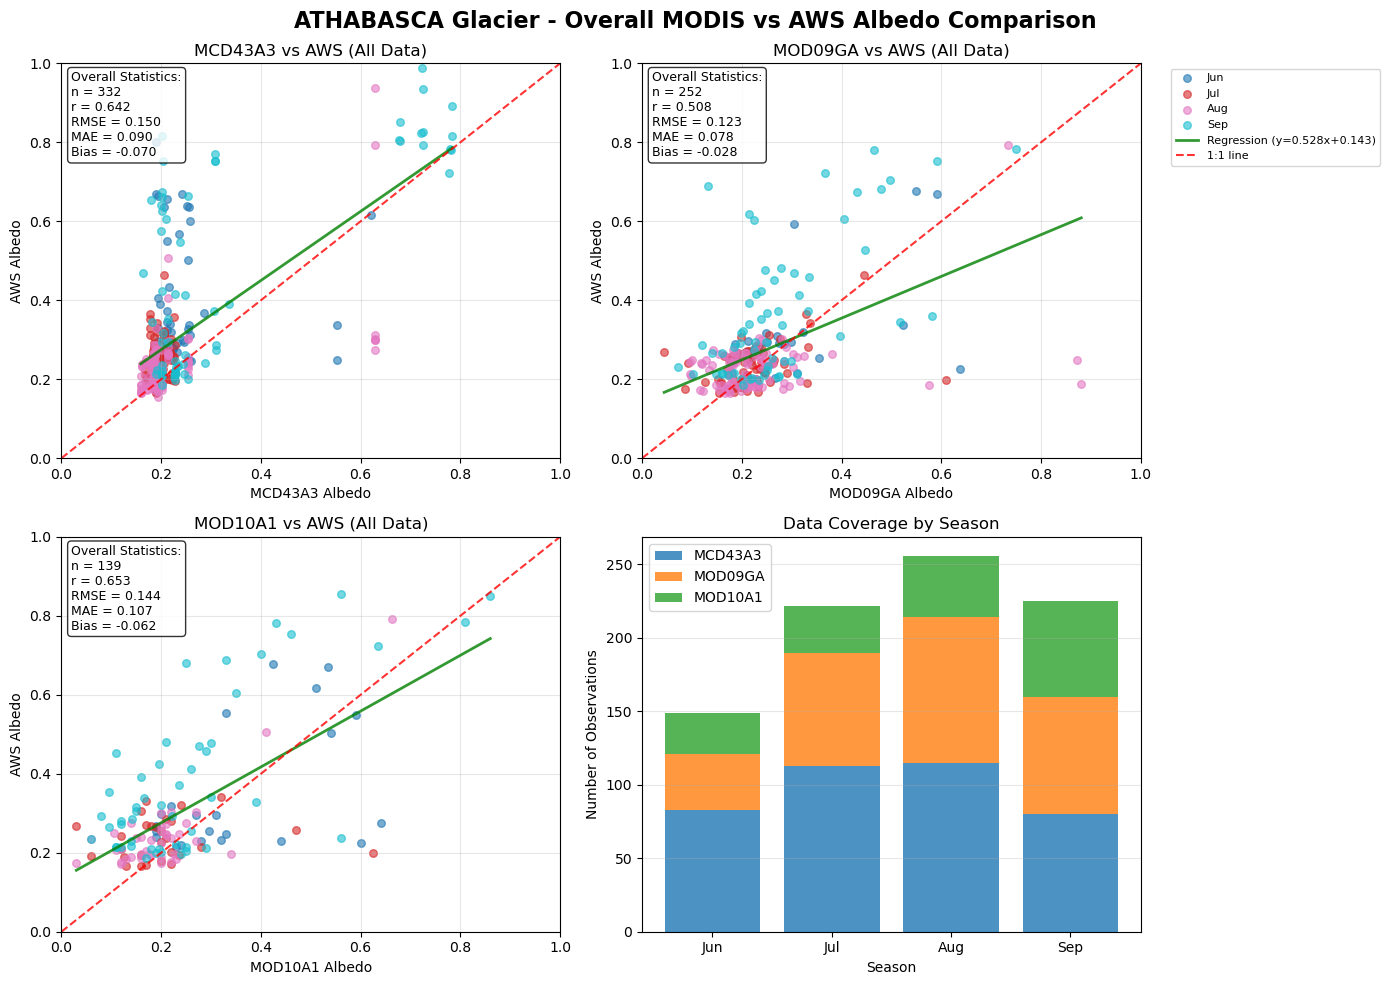


✅ Plot saved to: exports\athabasca_comprehensive_analysis.png

Overall analysis results for ATHABASCA:

MCD43A3:
  Total valid observations: 332
  Correlation: 0.642
  RMSE: 0.150
  MAE: 0.090
  Bias: -0.070

MOD09GA:
  Total valid observations: 252
  Correlation: 0.508
  RMSE: 0.123
  MAE: 0.078
  Bias: -0.028

MOD10A1:
  Total valid observations: 139
  Correlation: 0.653
  RMSE: 0.144
  MAE: 0.107
  Bias: -0.062


In [8]:
# Create comprehensive scatter plots for overall method comparison
from scipy import stats as scipy_stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'{GLACIER.upper()} Glacier - Overall MODIS vs AWS Albedo Comparison', fontsize=16, fontweight='bold')

# Extract month data for seasonal coloring
months = merged.index.month
unique_months = sorted(months.unique())
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'}
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_months)))

for i, method in enumerate(['MCD43A3', 'MOD09GA']):
    if method in merged.columns:
        ax = axes[0, i]
        
        # Calculate overall statistics for this method
        overall_valid = merged[[method, 'AWS']].dropna()
        if len(overall_valid) > 1:
            r, p = scipy_stats.pearsonr(overall_valid[method], overall_valid['AWS'])
            rmse = np.sqrt(np.mean((overall_valid[method] - overall_valid['AWS'])**2))
            mae = np.mean(np.abs(overall_valid[method] - overall_valid['AWS']))
            bias = np.mean(overall_valid[method] - overall_valid['AWS'])
            n_total = len(overall_valid)
            
            # Calculate regression line
            slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(overall_valid[method], overall_valid['AWS'])
        else:
            r, p, rmse, mae, bias, n_total = 0, 1, 0, 0, 0, 0
            slope, intercept = 0, 0
        
        # Plot all data points colored by season
        for month, color in zip(unique_months, colors):
            month_mask = months == month
            month_data = merged[month_mask]
            
            if len(month_data) > 0:
                valid_data = month_data[[method, 'AWS']].dropna()
                if len(valid_data) > 0:
                    month_label = month_names.get(month, f'Month {month}')
                    ax.scatter(valid_data[method], valid_data['AWS'], 
                             c=[color], alpha=0.6, s=30, 
                             label=month_label)
        
        # Add regression line
        if len(overall_valid) > 1:
            x_range = np.linspace(overall_valid[method].min(), overall_valid[method].max(), 100)
            y_pred = slope * x_range + intercept
            ax.plot(x_range, y_pred, 'g-', linewidth=2, alpha=0.8, 
                   label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
        
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.8, label='1:1 line')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel(f'{method} Albedo')
        ax.set_ylabel('AWS Albedo')
        ax.set_title(f'{method} vs AWS (All Data)')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text box
        stats_text = f'Overall Statistics:\nn = {n_total}\nr = {r:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}\nBias = {bias:.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        if i == 1:  # Only show legend on the right plot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# MOD10A1 in bottom left
if 'MOD10A1' in merged.columns:
    ax = axes[1, 0]
    
    # Calculate overall statistics for MOD10A1
    overall_valid = merged[['MOD10A1', 'AWS']].dropna()
    if len(overall_valid) > 1:
        r, p = scipy_stats.pearsonr(overall_valid['MOD10A1'], overall_valid['AWS'])
        rmse = np.sqrt(np.mean((overall_valid['MOD10A1'] - overall_valid['AWS'])**2))
        mae = np.mean(np.abs(overall_valid['MOD10A1'] - overall_valid['AWS']))
        bias = np.mean(overall_valid['MOD10A1'] - overall_valid['AWS'])
        n_total = len(overall_valid)
        
        # Calculate regression line
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(overall_valid['MOD10A1'], overall_valid['AWS'])
    else:
        r, p, rmse, mae, bias, n_total = 0, 1, 0, 0, 0, 0
        slope, intercept = 0, 0
    
    # Plot all data points colored by season
    for month, color in zip(unique_months, colors):
        month_mask = months == month
        month_data = merged[month_mask]
        
        if len(month_data) > 0:
            valid_data = month_data[['MOD10A1', 'AWS']].dropna()
            if len(valid_data) > 0:
                month_label = month_names.get(month, f'Month {month}')
                ax.scatter(valid_data['MOD10A1'], valid_data['AWS'], 
                         c=[color], alpha=0.6, s=30, 
                         label=month_label)
    
    # Add regression line
    if len(overall_valid) > 1:
        x_range = np.linspace(overall_valid['MOD10A1'].min(), overall_valid['MOD10A1'].max(), 100)
        y_pred = slope * x_range + intercept
        ax.plot(x_range, y_pred, 'g-', linewidth=2, alpha=0.8, 
               label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
    
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.8, label='1:1 line')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('MOD10A1 Albedo')
    ax.set_ylabel('AWS Albedo')
    ax.set_title('MOD10A1 vs AWS (All Data)')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'Overall Statistics:\nn = {n_total}\nr = {r:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}\nBias = {bias:.3f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Data coverage by season in bottom right
ax = axes[1, 1]
if len(unique_months) > 0:
    month_labels = [month_names.get(m, f'M{m}') for m in unique_months]
    
    # Collect data for all methods first
    methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
    data_matrix = []
    
    for method in methods:
        if method in merged.columns:
            counts = []
            for month in unique_months:
                month_mask = months == month
                count = merged[month_mask][method].notna().sum()
                counts.append(count)
            data_matrix.append(counts)
        else:
            data_matrix.append([0] * len(unique_months))
    
    # Create stacked bar chart
    bottom = np.zeros(len(unique_months))
    colors_methods = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, (method, method_counts) in enumerate(zip(methods, data_matrix)):
        if method in merged.columns and any(method_counts):
            ax.bar(month_labels, method_counts, bottom=bottom, 
                  label=method, color=colors_methods[i], alpha=0.8)
            bottom += np.array(method_counts)
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Number of Observations')
    ax.set_title('Data Coverage by Season')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(out('comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Plot saved to: {out('comprehensive_analysis.png')}")

# Print detailed statistics for each method
print(f"\nOverall analysis results for {GLACIER.upper()}:")
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in merged.columns:
        overall_valid = merged[[method, 'AWS']].dropna()
        if len(overall_valid) > 1:
            r, p = scipy_stats.pearsonr(overall_valid[method], overall_valid['AWS'])
            rmse = np.sqrt(np.mean((overall_valid[method] - overall_valid['AWS'])**2))
            mae = np.mean(np.abs(overall_valid[method] - overall_valid['AWS']))
            bias = np.mean(overall_valid[method] - overall_valid['AWS'])
            n_total = len(overall_valid)
            
            print(f"\n{method}:")
            print(f"  Total valid observations: {n_total}")
            print(f"  Correlation: {r:.3f}")
            print(f"  RMSE: {rmse:.3f}")
            print(f"  MAE: {mae:.3f}")
            print(f"  Bias: {bias:.3f}")

## 16-Day Composite Analysis

This section performs a 16-day composite analysis similar to Ren et al. (2023). MODIS data is commonly processed in 16-day composites to reduce cloud contamination and provide more stable albedo estimates. This analysis:

- Groups data into 16-day periods starting from day 1 of each year
- Calculates mean albedo values for each 16-day period
- Compares temporal patterns between MODIS methods and AWS
- Analyzes seasonal dynamics at the 16-day scale


### Calculate Statistics


In [9]:
# 16-Day Composite Analysis (Target months: Jun-Sep) - CALCULATE STATISTICS
import scipy.stats as scipy_stats

# Debug: Check merged structure and add temporal columns if needed
print("Available columns in merged:", merged.columns.tolist())
print("Merged shape:", merged.shape)

# Always create a working copy with all temporal columns
merged_copy = merged.reset_index()

# Add all necessary temporal columns
merged_copy['year'] = merged_copy['date'].dt.year
merged_copy['month'] = merged_copy['date'].dt.month  
merged_copy['doy'] = merged_copy['date'].dt.dayofyear
print("✓ Added temporal columns: year, month, doy")

# Create 16-day composites similar to MODIS standard compositing
def make_16day_composite(data, method_names):
    """Create 16-day composites from daily data"""
    # Create 16-day periods (standard MODIS compositing)
    # Each year has roughly 23 16-day periods (23 * 16 = 368 days)
    data = data.copy()
    data['period_16day'] = ((data['doy'] - 1) // 16) + 1
    
    # Group by year and 16-day period, calculate means
    composite_data = data.groupby(['year', 'period_16day']).agg({
        **{f'{m}': 'mean' for m in method_names}, 
        'AWS': 'mean'
    }).reset_index()
    
    # Add mean column names for clarity
    for method in method_names:
        composite_data[f'{method}_mean'] = composite_data[method]
    composite_data['AWS_mean'] = composite_data['AWS']
    
    return composite_data

# Create 16-day composites (focus on ablation season: Jun-Sep)
target_months = [6, 7, 8, 9]
ablation_data = merged_copy[merged_copy['month'].isin(target_months)]
composite_16day = make_16day_composite(ablation_data, ['MCD43A3', 'MOD09GA', 'MOD10A1'])

print(f"16-day composite periods: {len(composite_16day)}")

# Calculate enhanced statistics for 16-day composites  
composite_stats = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    aws_col = 'AWS_mean'
    method_col = f'{method}_mean'
    valid_data = composite_16day[[method_col, aws_col]].dropna()
    
    if len(valid_data) > 0:
        x, y = valid_data[method_col], valid_data[aws_col]
        r, p = scipy_stats.pearsonr(x, y)
        
        # Basic statistics
        diff = x - y
        abs_diff = np.abs(diff)
        rel_diff = diff / y * 100  # Relative difference in %
        
        # Regression analysis
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)
        
        # Outlier detection (values > 2 standard deviations)
        z_scores = np.abs(scipy_stats.zscore(diff))
        outliers = z_scores > 2
        n_outliers = np.sum(outliers)
        
        # Store comprehensive statistics
        composite_stats[method] = {
            # Sample size
            'n_periods': len(valid_data),
            'n_outliers': n_outliers,
            'outlier_pct': (n_outliers / len(valid_data)) * 100,
            
            # Correlation metrics
            'r': r, 'p': p, 'r_squared': r**2,
            
            # Error metrics
            'rmse': np.sqrt(np.mean(diff**2)),
            'mae': np.mean(abs_diff),
            'bias': np.mean(diff),
            'med_abs_error': np.median(abs_diff),
            'std_error': np.std(diff),
            
            # Relative metrics
            'mean_rel_bias': np.mean(rel_diff),
            'mean_abs_rel_error': np.mean(np.abs(rel_diff)),
            
            # Regression metrics
            'slope': slope,
            'intercept': intercept,
            'slope_stderr': std_err,
            
            # Range and distribution
            'sat_mean': np.mean(x), 'sat_std': np.std(x),
            'aws_mean': np.mean(y), 'aws_std': np.std(y),
            'sat_range': np.ptp(x), 'aws_range': np.ptp(y),
            
            # Agreement metrics
            'within_5pct': np.sum(np.abs(rel_diff) <= 5) / len(valid_data) * 100,
            'within_10pct': np.sum(np.abs(rel_diff) <= 10) / len(valid_data) * 100,
            'within_15pct': np.sum(np.abs(rel_diff) <= 15) / len(valid_data) * 100,
            
            'data': valid_data
        }

print(f"✓ Calculated enhanced statistics for {len(composite_stats)} methods")

Available columns in merged: ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']
Merged shape: (515, 4)
✓ Added temporal columns: year, month, doy
16-day composite periods: 53
✓ Calculated enhanced statistics for 3 methods


###  Validation Results

In [10]:
# 16-DAY COMPOSITE ANALYSIS - DISPLAY RESULTS
print("="*50)
print("Output 1: 16-DAY COMPOSITE ANALYSIS")
print("="*50)
print(f"Total 16-day periods analyzed: {len(composite_16day)}")

# Get basic info about the dataset
if len(composite_16day) > 0:
    years = composite_16day['year'].unique()
    periods = composite_16day['period_16day'].unique()
    
    print(f"Year range: {years.min()} - {years.max()}")
    print(f"Period range: {periods.min()} - {periods.max()}")
    
    # Handle date range more carefully - check if index contains actual dates
    if hasattr(composite_16day.index, 'strftime'):
        # Index contains datetime objects
        print(f"Date range: {composite_16day.index.min().strftime('%Y-%m-%d')} to {composite_16day.index.max().strftime('%Y-%m-%d')}")
    elif 'date' in composite_16day.columns:
        # Use date column if available
        date_col = composite_16day['date']
        if hasattr(date_col.iloc[0], 'strftime'):
            print(f"Date range: {date_col.min().strftime('%Y-%m-%d')} to {date_col.max().strftime('%Y-%m-%d')}")
        else:
            print(f"Date range: {date_col.min()} to {date_col.max()}")
    else:
        print("Date range: Index-based (no datetime information available)")

print("="*50)

# Display sample data
print("\nSample 16-day composites:")
preview_cols = ['year', 'period_16day', 'MCD43A3_mean', 'MOD09GA_mean', 'MOD10A1_mean', 'AWS_mean']
cols_show = [col for col in preview_cols if col in composite_16day.columns]
print(composite_16day[cols_show].head(10).to_string(index=True))

# Create comprehensive results display
print("\n=== 16-DAY COMPOSITE VALIDATION SUMMARY ===\n")

# Create detailed statistics table
stats_table = []
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in composite_stats:
        s_stat = composite_stats[method]
        stats_table.append([
            method,
            s_stat['n_periods'],
            f"{s_stat['r']:.3f}",
            f"{s_stat['r_squared']:.3f}",
            f"{s_stat['p']:.2e}" if s_stat['p'] < 0.001 else f"{s_stat['p']:.3f}",
            f"{s_stat['rmse']:.3f}",
            f"{s_stat['mae']:.3f}",
            f"{s_stat['bias']:.3f}",
            f"{s_stat['mean_abs_rel_error']:.1f}%",
            f"{s_stat['within_10pct']:.1f}%"
        ])

# Print formatted table
headers = ['Method', 'N', 'R', 'R²', 'p-value', 'RMSE', 'MAE', 'Bias', 'MARE%', 'Within±10%']
col_widths = [8, 4, 6, 6, 8, 6, 6, 7, 7, 10]

print(" ".join(h.ljust(w) for h, w in zip(headers, col_widths)))
print("-" * sum(col_widths) + "-" * (len(col_widths) - 1))
for row in stats_table:
    print(" ".join(str(val).ljust(w) for val, w in zip(row, col_widths)))

print("\n=== DETAILED STATISTICS BY METHOD ===")
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in composite_stats:
        s_stat = composite_stats[method]
        print(f"\n{method}:")
        print(f"  Sample size: {s_stat['n_periods']} 16-day periods")
        print(f"  Correlation: r={s_stat['r']:.3f}, R²={s_stat['r_squared']:.3f}, p={s_stat['p']:.3e}")
        print(f"  Error metrics: RMSE={s_stat['rmse']:.3f}, MAE={s_stat['mae']:.3f}, Bias={s_stat['bias']:.3f}")
        print(f"  Relative error: {s_stat['mean_abs_rel_error']:.1f}% (MARE), {s_stat['mean_rel_bias']:.1f}% (bias)")
        print(f"  Regression: slope={s_stat['slope']:.3f}±{s_stat['slope_stderr']:.3f}, intercept={s_stat['intercept']:.3f}")
        print(f"  Agreement: {s_stat['within_5pct']:.1f}% within ±5%, {s_stat['within_10pct']:.1f}% within ±10%, {s_stat['within_15pct']:.1f}% within ±15%")
        print(f"  Data ranges: Satellite [{s_stat['sat_mean']:.3f}±{s_stat['sat_std']:.3f}], AWS [{s_stat['aws_mean']:.3f}±{s_stat['aws_std']:.3f}]")
        print(f"  Outliers: {s_stat['n_outliers']}/{s_stat['n_periods']} ({s_stat['outlier_pct']:.1f}%) beyond 2σ")

# Print key insights
if composite_stats:
    print("\n=== KEY INSIGHTS ===")
    best_r = max(composite_stats.keys(), key=lambda k: composite_stats[k]['r'])
    best_rmse = min(composite_stats.keys(), key=lambda k: composite_stats[k]['rmse'])
    best_agreement = max(composite_stats.keys(), key=lambda k: composite_stats[k]['within_10pct'])

    print(f"• Best correlation: {best_r} (r={composite_stats[best_r]['r']:.3f})")
    print(f"• Lowest RMSE: {best_rmse} ({composite_stats[best_rmse]['rmse']:.3f})")
    print(f"• Best agreement: {best_agreement} ({composite_stats[best_agreement]['within_10pct']:.1f}% within ±10%)")

    # Performance ranking
    print(f"\n• Performance ranking (by R²): ", end="")
    ranked_methods = sorted(composite_stats.keys(), key=lambda k: composite_stats[k]['r_squared'], reverse=True)
    print(" > ".join([f"{m} ({composite_stats[m]['r_squared']:.3f})" for m in ranked_methods]))

Output 1: 16-DAY COMPOSITE ANALYSIS
Total 16-day periods analyzed: 53
Year range: 2014 - 2020
Period range: 10 - 18
Date range: Index-based (no datetime information available)

Sample 16-day composites:
   year  period_16day  MCD43A3_mean  MOD09GA_mean  MOD10A1_mean  AWS_mean
0  2014            16      0.203500      0.591241      0.460000  0.753022
1  2014            17      0.235750      0.288644      0.254375  0.404572
2  2015            10      0.290625      0.232188      0.312500       NaN
3  2015            11      0.248375      0.287493      0.316667       NaN
4  2015            12      0.204687      0.210697      0.151250       NaN
5  2015            13      0.198000      0.268973      0.146667  0.325992
6  2015            14      0.187462      0.224864      0.226667  0.280643
7  2015            15      0.436538      0.285339      0.353125  0.378121
8  2015            16      0.251400      0.214825      0.254500  0.378152
9  2015            17      0.323083      0.493195      0.

### Plots Visualization

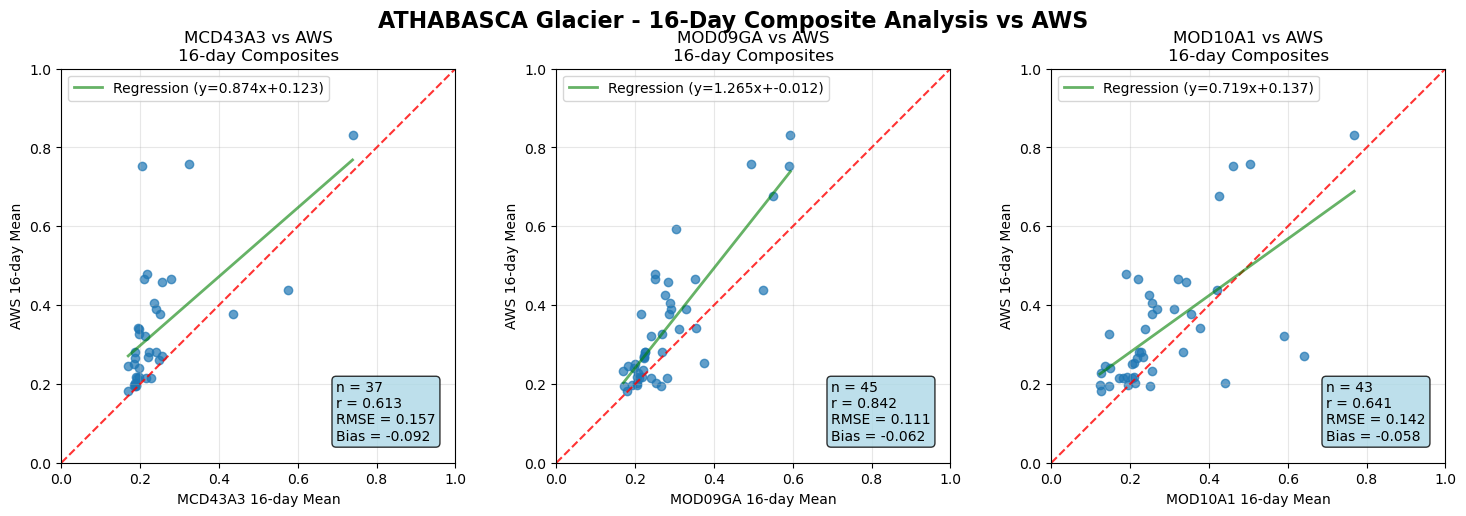


16-day composite analysis results for ATHABASCA:

MCD43A3:
  Valid 16-day periods: 37
  Correlation: 0.613
  RMSE: 0.157
  MAE: 0.104
  Bias: -0.092

MOD09GA:
  Valid 16-day periods: 45
  Correlation: 0.842
  RMSE: 0.111
  MAE: 0.082
  Bias: -0.062

MOD10A1:
  Valid 16-day periods: 43
  Correlation: 0.641
  RMSE: 0.142
  MAE: 0.107
  Bias: -0.058


In [11]:
# Create comprehensive 16-day analysis visualization
fig, axes = plt.subplots(1, len(composite_stats), figsize=(5*len(composite_stats), 5))
if len(composite_stats) == 1:
    axes = [axes]

fig.suptitle(f'{GLACIER.upper()} Glacier - 16-Day Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(composite_stats.items()):
    if stats_dict['n_periods'] > 0:
        data = stats_dict['data']
        method_col = f'{method}_mean'
        aws_col = 'AWS_mean'
        
        # Scatter plot
        ax = axes[i]
        ax.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        
        # Add regression line
        x = data[method_col]
        y = data[aws_col]
        slope = stats_dict['slope']
        intercept = stats_dict['intercept']
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = slope * x_range + intercept
        ax.plot(x_range, y_pred, 'g-', linewidth=2, alpha=0.6, label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel(f'{method} 16-day Mean')
        ax.set_ylabel('AWS 16-day Mean')
        ax.set_title(f'{method} vs AWS\n16-day Composites')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
        ax.set_aspect('equal')  # Keep scatter plots square
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax.text(0.95, 0.05, stats_text, transform=ax.transAxes,
                verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                multialignment='left')
    else:
        axes[i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                    ha='center', va='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.savefig(out('16day_composite_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n16-day composite analysis results for {GLACIER.upper()}:")
for method, stats_dict in composite_stats.items():
    if stats_dict['n_periods'] > 0:
        print(f"\n{method}:")
        print(f"  Valid 16-day periods: {stats_dict['n_periods']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for 16-day composite analysis")

## Weekly Composite Analysis

This section performs a weekly (7-day) composite analysis to compare with the 16-day approach.


In [12]:
# Weekly Composite Analysis (Target months: Jun-Sep) - CALCULATE STATISTICS
import scipy.stats as scipy_stats

# Debug: Check merged structure and add temporal columns if needed
print("Available columns in merged:", merged.columns.tolist())
print("Merged shape:", merged.shape)

# Add temporal columns if they don't exist
if 'month' not in merged.columns:
    merged = merged.reset_index()
    merged['year'] = merged['date'].dt.year
    merged['month'] = merged['date'].dt.month  
    merged['week'] = merged['date'].dt.isocalendar().year.astype(str) + '-W' + merged['date'].dt.isocalendar().week.astype(str).str.zfill(2)
    merged['doy'] = merged['date'].dt.dayofyear
    print("✓ Added temporal columns")

# Set target months for ablation season (Jun-Sep: 6-9)
target_months = [6, 7, 8, 9]

# Create weekly composites with helper function
def make_weekly_composite(method_names):
    weekly_data = merged[merged['month'].isin(target_months)].groupby('week').agg({
        **{f'{m}': 'mean' for m in method_names}, 'AWS': 'mean'
    }).reset_index()
    # Create year column for easier datetime conversion
    weekly_data['year'] = weekly_data['week'].str[:4].astype(int)
    weekly_data['week_num'] = weekly_data['week'].str[6:].astype(int)
    return weekly_data

composite_weekly = make_weekly_composite(['MCD43A3', 'MOD09GA', 'MOD10A1'])
print(f"Weekly composite periods: {len(composite_weekly)}")

# Calculate enhanced statistics for weekly composites
weekly_stats = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    aws_col = 'AWS'
    valid_data = composite_weekly[[method, aws_col]].dropna()
    
    if len(valid_data) > 0:
        x, y = valid_data[method], valid_data[aws_col]
        r, p = scipy_stats.pearsonr(x, y)
        
        # Basic statistics
        diff = x - y
        abs_diff = np.abs(diff)
        rel_diff = diff / y * 100  # Relative difference in %
        
        # Regression analysis
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)
        
        # Outlier detection (values > 2 standard deviations)
        z_scores = np.abs(scipy_stats.zscore(diff))
        outliers = z_scores > 2
        n_outliers = np.sum(outliers)
        
        # Additional metrics
        weekly_stats[method] = {
            # Sample size
            'n_periods': len(valid_data),
            'n_outliers': n_outliers,
            'outlier_pct': (n_outliers / len(valid_data)) * 100,
            
            # Correlation metrics
            'r': r, 'p': p, 'r_squared': r**2,
            
            # Error metrics
            'rmse': np.sqrt(np.mean(diff**2)),
            'mae': np.mean(abs_diff),
            'bias': np.mean(diff),
            'med_abs_error': np.median(abs_diff),
            'std_error': np.std(diff),
            
            # Relative metrics
            'mean_rel_bias': np.mean(rel_diff),
            'mean_abs_rel_error': np.mean(np.abs(rel_diff)),
            
            # Regression metrics
            'slope': slope,
            'intercept': intercept,
            'slope_stderr': std_err,
            
            # Range and distribution
            'sat_mean': np.mean(x), 'sat_std': np.std(x),
            'aws_mean': np.mean(y), 'aws_std': np.std(y),
            'sat_range': np.ptp(x), 'aws_range': np.ptp(y),
            
            # Agreement metrics
            'within_5pct': np.sum(np.abs(rel_diff) <= 5) / len(valid_data) * 100,
            'within_10pct': np.sum(np.abs(rel_diff) <= 10) / len(valid_data) * 100,
            'within_15pct': np.sum(np.abs(rel_diff) <= 15) / len(valid_data) * 100,
            
            'data': valid_data
        }

# Add quarterly breakdown calculation
weekly_months = []
for _, row in composite_weekly.iterrows():
    week_num = row['week_num']
    year = row['year']
    # Approximate month from week number (rough estimate)
    if week_num <= 13:
        month = 'Q1'
    elif week_num <= 26:
        month = 'Q2' 
    elif week_num <= 39:
        month = 'Q3'
    else:
        month = 'Q4'
    weekly_months.append(month)

composite_weekly['quarter'] = weekly_months
quarterly_counts = composite_weekly['quarter'].value_counts()

print(f"✓ Calculated enhanced statistics for {len(weekly_stats)} methods")

Available columns in merged: ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']
Merged shape: (515, 4)
✓ Added temporal columns
Weekly composite periods: 106
✓ Calculated enhanced statistics for 3 methods


In [13]:
# Weekly Composite Analysis - DISPLAY RESULTS
print("\n=== WEEKLY COMPOSITE VALIDATION SUMMARY ===\n")

# Create detailed statistics table
stats_table = []
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in weekly_stats:
        s = weekly_stats[method]
        stats_table.append([
            method,
            s['n_periods'],
            f"{s['r']:.3f}",
            f"{s['r_squared']:.3f}",
            f"{s['p']:.2e}" if s['p'] < 0.001 else f"{s['p']:.3f}",
            f"{s['rmse']:.3f}",
            f"{s['mae']:.3f}",
            f"{s['bias']:.3f}",
            f"{s['mean_abs_rel_error']:.1f}%",
            f"{s['within_10pct']:.1f}%"
        ])

# Print formatted table
headers = ['Method', 'N', 'R', 'R²', 'p-value', 'RMSE', 'MAE', 'Bias', 'MARE%', 'Within±10%']
col_widths = [8, 4, 6, 6, 8, 6, 6, 7, 7, 10]

print(" ".join(h.ljust(w) for h, w in zip(headers, col_widths)))
print("-" * sum(col_widths) + "-" * (len(col_widths) - 1))
for row in stats_table:
    print(" ".join(str(val).ljust(w) for val, w in zip(row, col_widths)))

print("\n=== DETAILED STATISTICS BY METHOD ===")
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in weekly_stats:
        s = weekly_stats[method]
        print(f"\n{method}:")
        print(f"  Sample size: {s['n_periods']} weekly periods")
        print(f"  Correlation: r={s['r']:.3f}, R²={s['r_squared']:.3f}, p={s['p']:.3e}")
        print(f"  Error metrics: RMSE={s['rmse']:.3f}, MAE={s['mae']:.3f}, Bias={s['bias']:.3f}")
        print(f"  Relative error: {s['mean_abs_rel_error']:.1f}% (MARE), {s['mean_rel_bias']:.1f}% (bias)")
        print(f"  Regression: slope={s['slope']:.3f}±{s['slope_stderr']:.3f}, intercept={s['intercept']:.3f}")
        print(f"  Agreement: {s['within_5pct']:.1f}% within ±5%, {s['within_10pct']:.1f}% within ±10%, {s['within_15pct']:.1f}% within ±15%")
        print(f"  Data ranges: Satellite [{s['sat_mean']:.3f}±{s['sat_std']:.3f}], AWS [{s['aws_mean']:.3f}±{s['aws_std']:.3f}]")
        print(f"  Outliers: {s['n_outliers']}/{s['n_periods']} ({s['outlier_pct']:.1f}%) beyond 2σ")

print(f"\nQuarterly breakdown: {', '.join([f'{q}: {count}' for q, count in quarterly_counts.items()])}")

# Print key insights
if weekly_stats:
    print("\n=== KEY INSIGHTS ===")
    best_r = max(weekly_stats.keys(), key=lambda k: weekly_stats[k]['r'])
    best_rmse = min(weekly_stats.keys(), key=lambda k: weekly_stats[k]['rmse'])
    best_agreement = max(weekly_stats.keys(), key=lambda k: weekly_stats[k]['within_10pct'])

    print(f"• Best correlation: {best_r} (r={weekly_stats[best_r]['r']:.3f})")
    print(f"• Lowest RMSE: {best_rmse} ({weekly_stats[best_rmse]['rmse']:.3f})")
    print(f"• Best agreement: {best_agreement} ({weekly_stats[best_agreement]['within_10pct']:.1f}% within ±10%)")

    # Performance ranking
    print(f"\n• Performance ranking (by R²): ", end="")
    ranked_methods = sorted(weekly_stats.keys(), key=lambda k: weekly_stats[k]['r_squared'], reverse=True)
    print(" > ".join([f"{m} ({weekly_stats[m]['r_squared']:.3f})" for m in ranked_methods]))


=== WEEKLY COMPOSITE VALIDATION SUMMARY ===

Method   N    R      R²     p-value  RMSE   MAE    Bias    MARE%   Within±10%
-----------------------------------------------------------------------------
MCD43A3  69   0.574  0.329  2.52e-07 0.161  0.109  -0.088  27.3%   30.4%     
MOD09GA  85   0.624  0.390  1.71e-10 0.126  0.087  -0.048  25.2%   22.4%     
MOD10A1  70   0.723  0.522  1.64e-12 0.134  0.103  -0.060  31.2%   12.9%     

=== DETAILED STATISTICS BY METHOD ===

MCD43A3:
  Sample size: 69 weekly periods
  Correlation: r=0.574, R²=0.329, p=2.519e-07
  Error metrics: RMSE=0.161, MAE=0.109, Bias=-0.088
  Relative error: 27.3% (MARE), -20.2% (bias)
  Regression: slope=0.763±0.133, intercept=0.146
  Agreement: 10.1% within ±5%, 30.4% within ±10%, 34.8% within ±15%
  Data ranges: Satellite [0.246±0.120], AWS [0.334±0.160]
  Outliers: 5/69 (7.2%) beyond 2σ

MOD09GA:
  Sample size: 85 weekly periods
  Correlation: r=0.624, R²=0.390, p=1.712e-10
  Error metrics: RMSE=0.126, MAE=0.087, 

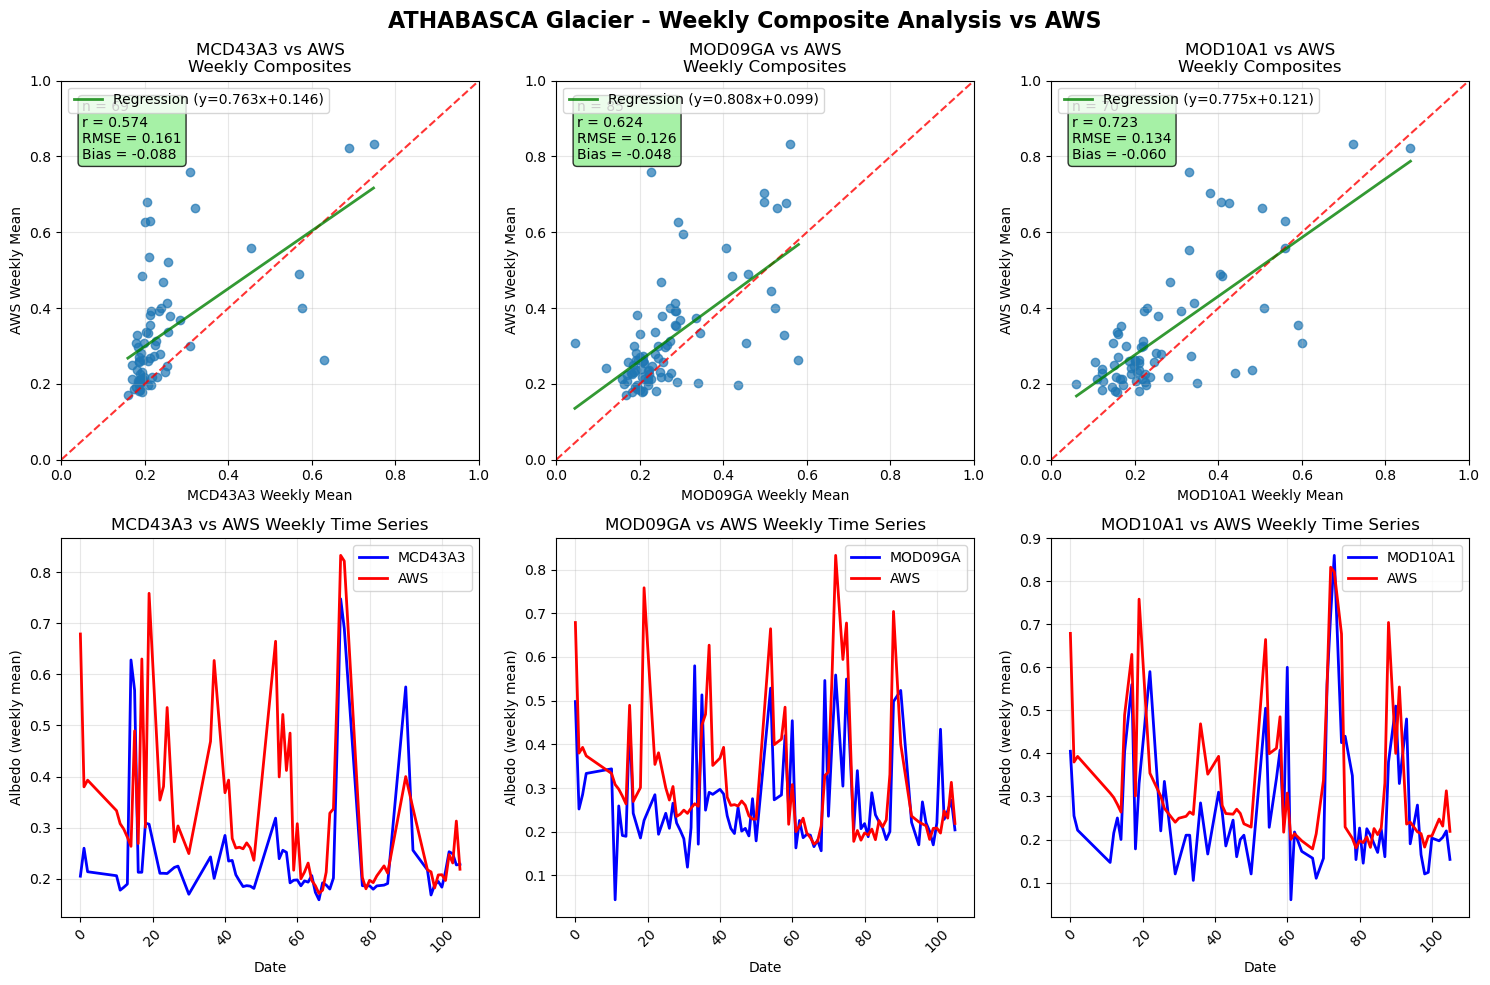


Weekly composite analysis results for ATHABASCA:

MCD43A3:
  Valid weekly periods: 69
  Correlation: 0.574
  RMSE: 0.161
  MAE: 0.109
  Bias: -0.088

MOD09GA:
  Valid weekly periods: 85
  Correlation: 0.624
  RMSE: 0.126
  MAE: 0.087
  Bias: -0.048

MOD10A1:
  Valid weekly periods: 70
  Correlation: 0.723
  RMSE: 0.134
  MAE: 0.103
  Bias: -0.060


In [15]:
# Create comprehensive weekly analysis visualization
fig, axes = plt.subplots(2, len(weekly_stats), figsize=(5*len(weekly_stats), 10))
if len(weekly_stats) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle(f'{GLACIER.upper()} Glacier - Weekly Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(weekly_stats.items()):
    if stats_dict['n_periods'] > 0 and 'data' in stats_dict and stats_dict['data'] is not None:
        data = stats_dict['data']
        # Use the actual column names from the data
        method_col = method  # Just the method name, not with '_mean'
        aws_col = 'AWS'     # Just 'AWS', not 'AWS_mean'
        
        # Scatter plot
        ax1 = axes[0, i]
        ax1.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax1.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        
        # Add regression line
        x = data[method_col]
        y = data[aws_col]
        slope = stats_dict['slope']
        intercept = stats_dict['intercept']
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = slope * x_range + intercept
        ax1.plot(x_range, y_pred, 'g-', linewidth=2, alpha=0.8, label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
        
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(f'{method} Weekly Mean')
        ax1.set_ylabel('AWS Weekly Mean')
        ax1.set_title(f'{method} vs AWS\nWeekly Composites')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        
        # Time series
        ax2 = axes[1, i]
        ax2.plot(data.index, data[method_col], 'b-', label=f'{method}', linewidth=2)
        ax2.plot(data.index, data[aws_col], 'r-', label='AWS', linewidth=2)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Albedo (weekly mean)')
        ax2.set_title(f'{method} vs AWS Weekly Time Series')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    else:
        axes[0, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.savefig(f'exports/{GLACIER}_weekly_composite_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nWeekly composite analysis results for {GLACIER.upper()}:")
for method, stats_dict in weekly_stats.items():
    if stats_dict['n_periods'] > 0:
        print(f"\n{method}:")
        print(f"  Valid weekly periods: {stats_dict['n_periods']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for weekly composite analysis")

## Monthly Analysis by Method

This section analyzes albedo patterns by month to understand seasonal variations and how different MODIS methods perform across different times of the year. 

In [ ]:
# ==============================================================================
# MONTHLY STATISTICS BY METHOD - CALCULATE STATISTICS
# ==============================================================================

from scipy import stats as scipy_stats  # Rename to avoid conflict

# First, let's check if merged has a date column and set it as index if needed
if 'date' in merged.columns and not isinstance(merged.index, pd.DatetimeIndex):
    merged = merged.set_index('date')

# Extract month from index (now it should be a DatetimeIndex)
merged['month'] = merged.index.month
target_months = [6, 7, 8, 9]  # June, July, August, September
months = merged['month']

print("MONTHLY STATISTICS BY METHOD")
print("="*50)

monthly_stats = {}
for month in target_months:
    month_mask = months == month
    month_data = merged[month_mask]
    
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            valid_data = month_data[[method, 'AWS']].dropna()
            
            if len(valid_data) >= 5:  # Minimum 5 observations
                x = valid_data[method]
                y = valid_data['AWS']
                
                # Basic correlation
                r, p = scipy_stats.pearsonr(x, y)
                
                # Basic statistics
                diff = x - y
                abs_diff = np.abs(diff)
                rel_diff = diff / y * 100  # Relative difference in %
                
                # Regression analysis
                slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)
                
                # Outlier detection (values > 2 standard deviations)
                z_scores = np.abs(scipy_stats.zscore(diff))
                outliers = z_scores > 2
                n_outliers = np.sum(outliers)
                
                # Store comprehensive statistics
                monthly_stats[f"{month}_{method}"] = {
                    # Sample size and outliers
                    'month': month,
                    'method': method,
                    'n': len(valid_data),
                    'n_outliers': n_outliers,
                    'outlier_pct': (n_outliers / len(valid_data)) * 100,
                    
                    # Correlation metrics
                    'r': r, 'p': p, 'r_squared': r**2,
                    
                    # Error metrics
                    'rmse': np.sqrt(np.mean(diff**2)),
                    'mae': np.mean(abs_diff),
                    'bias': np.mean(diff),
                    'med_abs_error': np.median(abs_diff),
                    'std_error': np.std(diff),
                    
                    # Relative metrics
                    'mean_rel_bias': np.mean(rel_diff),
                    'mean_abs_rel_error': np.mean(np.abs(rel_diff)),
                    
                    # Regression metrics
                    'slope': slope,
                    'intercept': intercept,
                    'slope_stderr': std_err,
                    
                    # Range and distribution
                    'sat_mean': np.mean(x), 'sat_std': np.std(x),
                    'aws_mean': np.mean(y), 'aws_std': np.std(y),
                    'sat_range': np.ptp(x), 'aws_range': np.ptp(y),
                    
                    # Agreement metrics
                    'within_5pct': np.sum(np.abs(rel_diff) <= 5) / len(valid_data) * 100,
                    'within_10pct': np.sum(np.abs(rel_diff) <= 10) / len(valid_data) * 100,
                    'within_15pct': np.sum(np.abs(rel_diff) <= 15) / len(valid_data) * 100,
                    
                    'data': valid_data
                }

print(f"✓ Calculated monthly statistics for {len(monthly_stats)} method-month combinations")

MONTHLY STATISTICS BY METHOD
✓ Calculated monthly statistics for 12 method-month combinations


In [ ]:
# ==============================================================================
# MONTHLY STATISTICS BY METHOD - DISPLAY RESULTS
# ==============================================================================

# Create comprehensive monthly statistics table
print("\n=== MONTHLY VALIDATION SUMMARY ===\n")

# Create detailed statistics table by month
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep'}

# Print headers
headers = ['Month', 'Method', 'N', 'R', 'R²', 'p-value', 'RMSE', 'MAE', 'Bias', 'MARE%', 'Within±10%']
col_widths = [6, 8, 4, 6, 6, 8, 6, 6, 7, 7, 10]

print(" ".join(h.ljust(w) for h, w in zip(headers, col_widths)))
print("-" * sum(col_widths) + "-" * (len(col_widths) - 1))

# Print statistics for each month and method
for month in target_months:
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        key = f"{month}_{method}"
        if key in monthly_stats:
            s = monthly_stats[key]
            row = [
                month_names[month],
                method,
                s['n'],
                f"{s['r']:.3f}",
                f"{s['r_squared']:.3f}",
                f"{s['p']:.2e}" if s['p'] < 0.001 else f"{s['p']:.3f}",
                f"{s['rmse']:.3f}",
                f"{s['mae']:.3f}",
                f"{s['bias']:.3f}",
                f"{s['mean_abs_rel_error']:.1f}%",
                f"{s['within_10pct']:.1f}%"
            ]
            print(" ".join(str(val).ljust(w) for val, w in zip(row, col_widths)))

print(f"\n=== DETAILED STATISTICS BY MONTH ===")

# Summary by month
for month in target_months:
    month_name = month_names[month]
    print(f"\n{month_name.upper()} ({month}):")
    print("-" * 30)
    
    month_methods = {k: v for k, v in monthly_stats.items() if v['month'] == month}
    
    if month_methods:
        # Find best performing method for this month
        best_r = max(month_methods.values(), key=lambda x: x['r'])
        best_rmse = min(month_methods.values(), key=lambda x: x['rmse'])
        best_agreement = max(month_methods.values(), key=lambda x: x['within_10pct'])
        
        print(f"• Best correlation: {best_r['method']} (r={best_r['r']:.3f})")
        print(f"• Lowest RMSE: {best_rmse['method']} ({best_rmse['rmse']:.3f})")
        print(f"• Best agreement: {best_agreement['method']} ({best_agreement['within_10pct']:.1f}% within ±10%)")
        
        # Performance ranking for this month
        ranked_methods = sorted(month_methods.values(), key=lambda x: x['r_squared'], reverse=True)
        print(f"• Performance ranking (by R²): ", end="")
        print(" > ".join([f"{m['method']} ({m['r_squared']:.3f})" for m in ranked_methods]))

print(f"\nAnalyzed months: June-September")
print(f"Total observations across all methods and months: {len(merged[merged['month'].isin(target_months)])}")
print(f"Statistics computed with minimum 5 observations per method per month")


=== MONTHLY VALIDATION SUMMARY ===

Month  Method   N    R      R²     p-value  RMSE   MAE    Bias    MARE%   Within±10%
------------------------------------------------------------------------------------
Jun    MCD43A3  54   0.089  0.008  0.521    0.217  0.153  -0.133  34.2%   14.8%     
Jun    MOD09GA  27   0.552  0.304  0.003    0.119  0.080  -0.011  27.0%   18.5%     
Jun    MOD10A1  22   0.494  0.244  0.019    0.153  0.112  0.010   36.3%   27.3%     
Jul    MCD43A3  100  0.151  0.023  0.133    0.070  0.052  -0.047  19.1%   32.0%     
Jul    MOD09GA  69   0.363  0.132  0.002    0.075  0.048  -0.012  21.3%   31.9%     
Jul    MOD10A1  28   0.074  0.005  0.708    0.124  0.088  -0.029  37.3%   14.3%     
Aug    MCD43A3  115  0.596  0.355  2.07e-12 0.095  0.057  -0.022  20.5%   34.8%     
Aug    MOD09GA  95   0.363  0.132  3.01e-04 0.121  0.068  -0.000  30.4%   27.4%     
Aug    MOD10A1  39   0.829  0.686  7.47e-11 0.076  0.063  -0.046  26.8%   12.8%     
Sep    MCD43A3  63   0.704  

### Plots Visualization

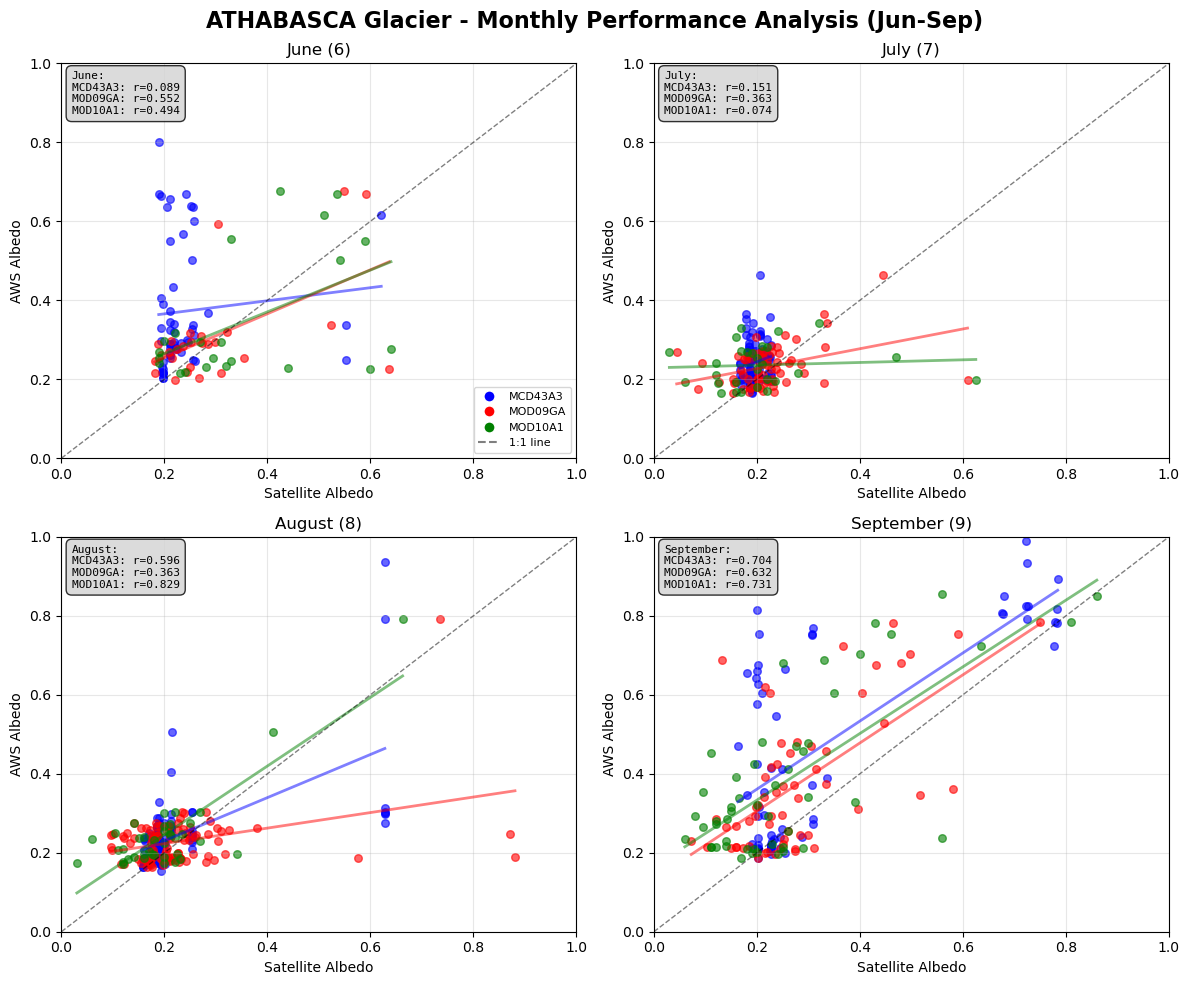

✓ Monthly scatter plots with embedded statistics saved to exports directory
  - athabasca_monthly_scatter_with_stats.png


In [ ]:
# ==============================================================================
# MONTHLY VISUALIZATION PLOTS
# ==============================================================================

# Create monthly scatter plots with embedded statistics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'{GLACIER.upper()} Glacier - Monthly Performance Analysis (Jun-Sep)', fontsize=16, fontweight='bold')

month_names = {6: 'June', 7: 'July', 8: 'August', 9: 'September'}
methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
method_colors = {'MCD43A3': 'blue', 'MOD09GA': 'red', 'MOD10A1': 'green'}

# Scatter plots for each month with embedded statistics
for i, month in enumerate(target_months):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    month_name = month_names[month]
    
    # Get data for this month
    month_mask = merged['month'] == month
    month_data = merged[month_mask]
    
    # Plot data for each method
    legend_elements = []
    stats_text = f"{month_name}:\n"
    
    for j, method in enumerate(methods):
        if method in merged.columns:
            valid_data = month_data[[method, 'AWS']].dropna()
            if len(valid_data) > 0:
                # Plot scatter points
                ax.scatter(valid_data[method], valid_data['AWS'], 
                          alpha=0.6, label=method, color=method_colors[method], s=30)
                
                # Get statistics for this method and month
                key = f"{month}_{method}"
                if key in monthly_stats:
                    stats = monthly_stats[key]
                    
                    # Plot regression line only over the data range
                    x_min, x_max = valid_data[method].min(), valid_data[method].max()
                    x_range = np.linspace(x_min, x_max, 50)
                    y_pred = stats['slope'] * x_range + stats['intercept']
                    ax.plot(x_range, y_pred, color=method_colors[method], 
                           linestyle='-', linewidth=2, alpha=0.5)
                    
                    # Add only correlation coefficient
                    stats_line = f"{method}: r={stats['r']:.3f}"
                    stats_text += f"{stats_line}\n"
    
    # Add 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='1:1 line')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Satellite Albedo')
    ax.set_ylabel('AWS Albedo')
    ax.set_title(f'{month_name} ({month})')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    ax.text(0.02, 0.98, stats_text.strip(), transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
            fontsize=8, family='monospace')
    
    # Add method legend only for the first plot (top-left)
    if i == 0:
        # Create legend with just method colors
        method_legend = [plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=method_colors[method], markersize=8, label=method)
                        for method in methods]
        method_legend.append(plt.Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='1:1 line'))
        ax.legend(handles=method_legend, loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(EXPORT_DIR / f'{GLACIER}_monthly_scatter_with_stats.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Monthly scatter plots with embedded statistics saved to exports directory")
print(f"  - {GLACIER}_monthly_scatter_with_stats.png")

## Spatial Analysis: Pixel-Level Comparisons and Map


### Part 1: Multi-Method Pixel Matching

This analysis identifies pixels where multiple MODIS methods (MCD43A3, MOD09GA, MOD10A1) have simultaneous observations, enabling direct method-to-method comparisons at identical spatial and temporal coordinates.

In [ ]:
# ===============================================================================
# PIXEL-LEVEL COMPARISON (MOD09GA vs MOD10A1 vs MCD43A3)
# ===============================================================================

# Filter for MOD09GA, MOD10A1, and MCD43A3 only
mod_data = modis[modis['method'].isin(['MOD09GA', 'MOD10A1', 'MCD43A3'])].copy()

# Find matching observations (same date and pixel_id)
mod09_data = mod_data[mod_data['method'] == 'MOD09GA'][['date', 'pixel_id', 'albedo_value']]
mod10_data = mod_data[mod_data['method'] == 'MOD10A1'][['date', 'pixel_id', 'albedo_value']]
mcd43a3_data = mod_data[mod_data['method'] == 'MCD43A3'][['date', 'pixel_id', 'albedo_value']]

# Merge MOD09GA and MOD10A1 on exact date and pixel_id matches
pixel_matched_09_10 = pd.merge(mod09_data, mod10_data, on=['date', 'pixel_id'], suffixes=('_MOD09GA', '_MOD10A1'))

# Merge all three (inner join: only dates/pixels present in all three)
pixel_matched_all = pd.merge(pixel_matched_09_10, mcd43a3_data, on=['date', 'pixel_id'])
pixel_matched_all = pixel_matched_all.rename(columns={'albedo_value': 'albedo_value_MCD43A3'})

print(f"Found {len(pixel_matched_09_10)} matching observations between MOD09GA and MOD10A1")
if len(pixel_matched_09_10) > 0:
    print(f"Date range: {pixel_matched_09_10['date'].min()} to {pixel_matched_09_10['date'].max()}")
    print(f"Unique pixels: {pixel_matched_09_10['pixel_id'].nunique()}")
    print(f"Pixel IDs: {sorted(pixel_matched_09_10['pixel_id'].unique())}")
else:
    print("No matching observations found for same date and pixel_id (MOD09GA vs MOD10A1)")

print(f"\nFound {len(pixel_matched_all)} matching observations between MOD09GA, MOD10A1, and MCD43A3")
if len(pixel_matched_all) > 0:
    print(f"Date range: {pixel_matched_all['date'].min()} to {pixel_matched_all['date'].max()}")
    print(f"Unique pixels: {pixel_matched_all['pixel_id'].nunique()}")
    print(f"Pixel IDs: {sorted(pixel_matched_all['pixel_id'].unique())}")
else:
    print("No matching observations found for same date and pixel_id (all three products)")

Found 160 matching observations between MOD09GA and MOD10A1
Date range: 2014-06-01 00:00:00 to 2020-09-30 00:00:00
Unique pixels: 2
Pixel IDs: [np.int64(9073025950), np.int64(9075025945)]

Found 64 matching observations between MOD09GA, MOD10A1, and MCD43A3
Date range: 2014-06-01 00:00:00 to 2020-09-27 00:00:00
Unique pixels: 2
Pixel IDs: [np.int64(9073025950), np.int64(9075025945)]


### Part 2: AWS Station Integration

This section processes the AWS (Automatic Weather Station) ground truth data, extracts station coordinates, and attempts to link AWS measurements with MODIS satellite observations at the same geographic location.

In [ ]:
# Process pixel AWS data to match the MODIS data structure
from scipy import stats as scipy_stats  # Rename to avoid conflict

# Get AWS coordinates from the spatial points (from shapefile)
if len(aws_points) > 0:
    aws_lat = aws_points.iloc[0]['latitude']
    aws_lon = aws_points.iloc[0]['longitude']
    
    # Create AWS pixel data structure
    pixel_aws = pd.DataFrame({
        'lat': [aws_lat],
        'lon': [aws_lon],
        'AWS': [aws['Albedo'].mean()]  # Use mean albedo as representative value
    })
    
    print(f"AWS station coordinates: lat={aws_lat:.6f}, lon={aws_lon:.6f}")
    print(f"AWS mean albedo: {aws['Albedo'].mean():.3f}")

    # If pixel_id for AWS is known, compare all three products at that pixel
    if 'pixel_id' in aws and 'date' in aws:
        # Find all MODIS products at AWS pixel and dates
        aws_pixel_id = aws['pixel_id'].iloc[0] if 'pixel_id' in aws.columns else None
        if aws_pixel_id is not None:
            aws_dates = aws['date'].unique() if 'date' in aws.columns else []
            for date in aws_dates:
                row = {'date': date}
                for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
                    val = modis[(modis['pixel_id'] == aws_pixel_id) & (modis['date'] == date) & (modis['method'] == method)]['albedo_value']
                    row[method] = val.iloc[0] if not val.empty else None
                row['AWS'] = aws[aws['date'] == date]['Albedo'].iloc[0] if not aws[aws['date'] == date].empty else None
                print(row)
else:
    print("No AWS points found.")

AWS station coordinates: lat=52.191833, lon=-117.251639
AWS mean albedo: 0.610


### Part 3: Spatial Visualization and Geographic Context

This comprehensive map integrates results from Parts 1 and 2, showing the spatial distribution of MODIS pixels (colored by method availability), AWS station location, and glacier mask boundary. This visualization reveals the geographic context that explains why certain method comparisons perform better or worse.

  CRS: EPSG:32611
  Bounds: BoundingBox(left=480900.0, bottom=5779700.0, right=485930.0, top=5787390.0)
✓ Sentinel-2 basemap re-projected to lon/lat
✓ Glacier boundary plotted
✓ 2 unique MODIS pixels plotted with ID labels
✓ AWS station plotted
✓ Map extent set to glacier mask bounds with buffer


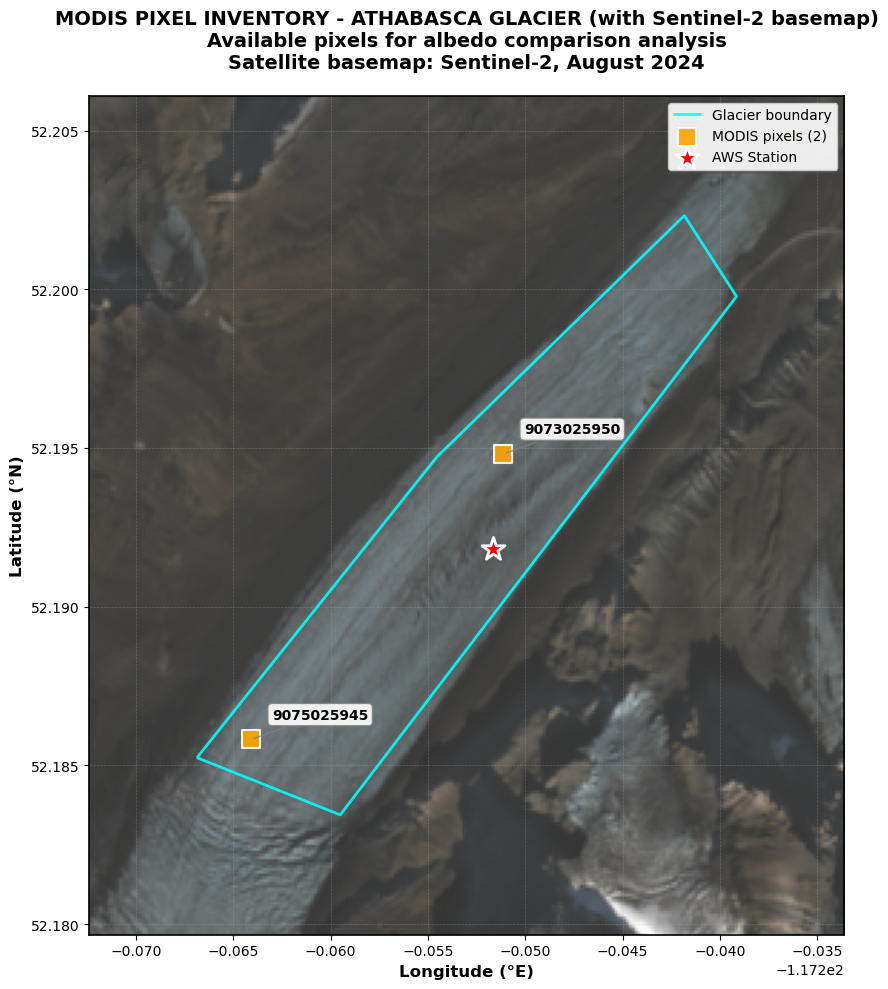

✅ Scientific map with basemap saved to: exports\athabasca_scientific_pixel_map_with_basemap.png


In [ ]:
# GeoTIFF path
GEOTIFF = Path("data/geotiff/athabasca_glacier_larger_s2_aug2024.tif")

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# 1) Sentinel-2 basemap ------------------------------------------------------
if GEOTIFF.exists():
    try:
        from rasterio.plot import show as rio_show
        from rasterio.warp import transform_bounds
        
        # Read and display the GeoTIFF basemap
        with rasterio.open(GEOTIFF) as src:
            print(f"  CRS: {src.crs}")
            print(f"  Bounds: {src.bounds}")
            
            # Convert raster bounds from UTM to WGS84 (lon/lat)
            lon_min_img, lat_min_img, lon_max_img, lat_max_img = transform_bounds(
                src.crs, "EPSG:4326", *src.bounds, densify_pts=21
            )
            
            # Read RGB bands and prepare for display
            img = src.read([1, 2, 3])  # RGB bands
            rgb = np.moveaxis(img, 0, -1)  # Move color axis to match imshow: (rows, cols, bands)
            rgb = rgb / np.clip(rgb.max(), 1, None)  # Normalize for display
            
            # Display the basemap using imshow with correct extent
            ax.imshow(
                rgb,
                extent=[lon_min_img, lon_max_img, lat_min_img, lat_max_img],
                origin="upper",
                zorder=0,
                alpha=0.8
            )
            
            # Store bounds for map extent
            t_bounds = (lon_min_img, lat_min_img, lon_max_img, lat_max_img)
            print(f"✓ Sentinel-2 basemap re-projected to lon/lat")
            
    except Exception as e:
        print(f"⚠ Could not load GeoTIFF basemap: {e}")
        t_bounds = None
else:
    print(f"⚠ GeoTIFF file not found: {GEOTIFF}")
    t_bounds = None

# 2) Plot glacier boundary ---------------------------------------------------
if glacier_mask is not None and not glacier_mask.empty:
    glacier_mask.boundary.plot(ax=ax, color='cyan', linewidth=2, alpha=0.9, zorder=2, label='Glacier boundary')
    print("✓ Glacier boundary plotted")

# 3) Plot MODIS pixels -------------------------------------------------------
# Use pixels_gdf (GeoDataFrame) which should have geometry coordinates
if 'pixels_gdf' in globals() and not pixels_gdf.empty:
    # Get unique pixel locations only
    unique_pixels = pixels_gdf.drop_duplicates(subset=['geometry'])
    
    # Plot using the geometry from the unique pixels
    ax.scatter(
        unique_pixels.geometry.x, unique_pixels.geometry.y,
        c='orange', s=180, marker='s', alpha=0.9,
        edgecolors='white', linewidths=1.5, zorder=4,
        label=f"MODIS pixels ({len(unique_pixels)})"
    )
    
    # Add pixel ID labels with connecting lines
    for idx, row in unique_pixels.iterrows():
        pixel_id = getattr(row, 'pixel_id', idx)  # Use pixel_id if available, otherwise use index
        ax.annotate(
            str(pixel_id), 
            (row.geometry.x, row.geometry.y),
            xytext=(15, 15), textcoords='offset points',
            fontsize=10, fontweight='bold', color='black',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'),
            arrowprops=dict(arrowstyle='-', color='gray', lw=1, alpha=0.8),
            zorder=5
        )
    print(f"✓ {len(unique_pixels)} unique MODIS pixels plotted with ID labels")
elif 'all_lons' in globals() and 'all_lats' in globals():
    # Fallback to using all_lons and all_lats lists
    ax.scatter(
        all_lons, all_lats,
        c='orange', s=180, marker='s', alpha=0.9,
        edgecolors='white', linewidths=1.5, zorder=4,
        label=f"MODIS pixels ({len(all_lons)})"
    )
    
    # Add pixel ID labels with connecting lines for fallback
    for i, (lon, lat) in enumerate(zip(all_lons, all_lats)):
        ax.annotate(
            str(i+1), 
            (lon, lat),
            xytext=(15, 15), textcoords='offset points',
            fontsize=10, fontweight='bold', color='black',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'),
            arrowprops=dict(arrowstyle='-', color='gray', lw=1, alpha=0.8),
            zorder=5
        )
    print(f"✓ {len(all_lons)} MODIS pixels plotted with ID labels")
else:
    print("⚠ No pixel coordinate data available")

# 4) Plot AWS station --------------------------------------------------------
if aws_points is not None and not aws_points.empty:
    ax.scatter(
        aws_points.geometry.x, aws_points.geometry.y,
        c='red', s=300, marker='*', alpha=1.0,
        edgecolors='white', linewidths=2, zorder=5,
        label='AWS Station'
    )
    print("✓ AWS station plotted")

# 5) Map styling and extent --------------------------------------------------
# Use glacier mask bounds for map extent
if glacier_mask is not None and not glacier_mask.empty:
    # Get glacier mask bounds
    bounds = glacier_mask.bounds
    lon_min = bounds.minx.min()
    lon_max = bounds.maxx.max()  
    lat_min = bounds.miny.min()
    lat_max = bounds.maxy.max()
    
    # Add small buffer around glacier mask
    lon_buffer = (lon_max - lon_min) * 0.2  # 20% buffer (increased from 10%)
    lat_buffer = (lat_max - lat_min) * 0.2
    ax.set_xlim(lon_min - lon_buffer, lon_max + lon_buffer)
    ax.set_ylim(lat_min - lat_buffer, lat_max + lat_buffer)
    print(f"✓ Map extent set to glacier mask bounds with buffer")
elif t_bounds:
    # Fallback to GeoTIFF bounds if glacier mask not available
    lon_min, lat_min, lon_max, lat_max = t_bounds
    lon_buffer = (lon_max - lon_min) * 0.05
    lat_buffer = (lat_max - lat_min) * 0.05
    ax.set_xlim(lon_min - lon_buffer, lon_max + lon_buffer)
    ax.set_ylim(lat_min - lat_buffer, lat_max + lat_buffer)
    print(f"✓ Map extent set to GeoTIFF bounds with buffer")
else:
    # Final fallback extent
    ax.set_xlim(-117.27, -117.23)
    ax.set_ylim(52.18, 52.21)
    print(f"✓ Map extent set to default bounds")

# Scientific styling
ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')
ax.set_title(
    'MODIS PIXEL INVENTORY - ATHABASCA GLACIER (with Sentinel-2 basemap)\n'
    'Available pixels for albedo comparison analysis\n'
    'Satellite basemap: Sentinel-2, August 2024',
    fontsize=14, fontweight='bold', pad=20
)

# Legend
legend = ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

# Grid and spines
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# Final touches
plt.tight_layout()

# Save the plot
plt.savefig(out('scientific_pixel_map_with_basemap.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Scientific map with basemap saved to: {out('scientific_pixel_map_with_basemap.png')}")

## Outlier Detection and Analysis

This section identifies and analyzes outliers in the albedo data using Z-score analysis (threshold > 2.5) and compares statistics with and without outliers.

In [ ]:
# ==============================================================================
# OUTLIER DETECTION
# ==============================================================================
# Detect Z-score outliers (|z| > 2.5)
outliers = {}
outlier_counts = {}
outlier_values = {}
for col in ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']:
    if col in merged.columns:
        clean_data = merged[col].dropna()
        if len(clean_data) > 0:
            z = np.abs(stats.zscore(clean_data))
            outlier_mask = z > 3
            outliers[col] = pd.Series(outlier_mask, index=clean_data.index)
            outlier_counts[col] = outlier_mask.sum()
            # Store actual outlier values
            outlier_values[col] = clean_data[outlier_mask].sort_values()
        else:
            outliers[col] = pd.Series([], dtype=bool)
            outlier_counts[col] = 0
            outlier_values[col] = pd.Series([])

print("OUTLIER DETECTION RESULTS")
print("=" * 40)
for method, count in outlier_counts.items():
    total = merged[method].notna().sum() if method in merged.columns else 0
    pct = (count/total*100) if total > 0 else 0
    print(f"{method}: {count} outliers ({pct:.1f}% of {total} observations)")
print("=" * 40)

OUTLIER DETECTION RESULTS
MCD43A3: 22 outliers (5.6% of 391 observations)
MOD09GA: 8 outliers (2.7% of 294 observations)
MOD10A1: 3 outliers (1.8% of 167 observations)
AWS: 11 outliers (2.5% of 432 observations)


C:\Users\thier\AppData\Local\Temp\ipykernel_35528\344880838.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


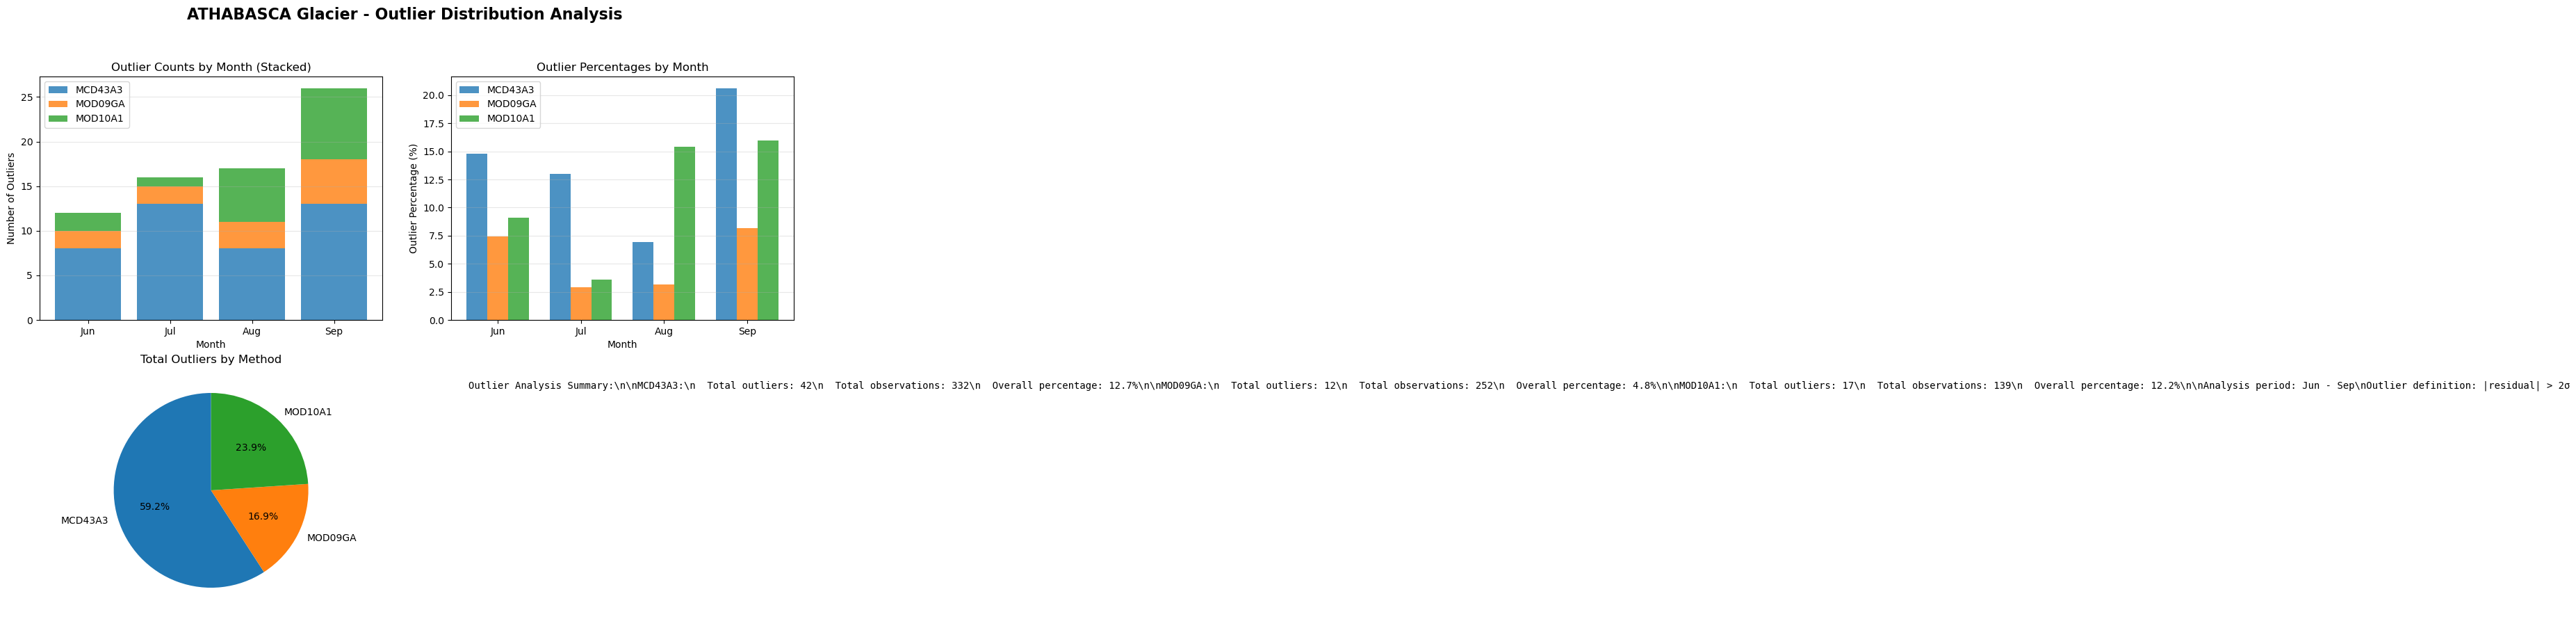

\n✅ Plot saved to: exports\athabasca_outliers_by_method_distribution.png


In [ ]:
# Create comprehensive outlier distribution visualization
if 'outlier_counts_by_month' in globals() and outlier_counts_by_month:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{GLACIER.upper()} Glacier - Outlier Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Extract data for visualization
    months = sorted(outlier_counts_by_month.keys())
    month_names = ['Jun', 'Jul', 'Aug', 'Sep']
    methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
    
    # Plot 1: Outlier counts by month (stacked bar)
    ax1 = axes[0, 0]
    bottom = np.zeros(len(months))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, method in enumerate(methods):
        counts = [outlier_counts_by_month[month].get(method, 0) for month in months]
        ax1.bar(month_names, counts, bottom=bottom, label=method, color=colors[i], alpha=0.8)
        bottom += counts
    
    ax1.set_title('Outlier Counts by Month (Stacked)')
    ax1.set_ylabel('Number of Outliers')
    ax1.set_xlabel('Month')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Outlier percentages by month
    ax2 = axes[0, 1]
    x = np.arange(len(months))
    width = 0.25
    
    for i, method in enumerate(methods):
        percentages = []
        for month in months:
            outlier_count = outlier_counts_by_month[month].get(method, 0)
            month_key = f"{month}_{method}"
            total_obs = monthly_stats[month_key]['n'] if month_key in monthly_stats else 1
            percentage = (outlier_count / total_obs * 100) if total_obs > 0 else 0
            percentages.append(percentage)
        
        ax2.bar(x + i*width, percentages, width, label=method, color=colors[i], alpha=0.8)
    
    ax2.set_title('Outlier Percentages by Month')
    ax2.set_ylabel('Outlier Percentage (%)')
    ax2.set_xlabel('Month')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(month_names)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Total outliers by method (pie chart)
    ax3 = axes[1, 0]
    total_outliers = {}
    for method in methods:
        total_outliers[method] = sum(outlier_counts_by_month[month].get(method, 0) for month in months)
    
    if any(total_outliers.values()):
        ax3.pie(total_outliers.values(), labels=total_outliers.keys(), autopct='%1.1f%%', 
               colors=colors, startangle=90)
        ax3.set_title('Total Outliers by Method')
    else:
        ax3.text(0.5, 0.5, 'No outliers detected', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Total Outliers by Method')
    
    # Plot 4: Summary statistics
    ax4 = axes[1, 1]
    summary_text = "Outlier Analysis Summary:\\n\\n"
    
    for method in methods:
        total_outliers_method = sum(outlier_counts_by_month[month].get(method, 0) for month in months)
        total_obs_method = sum(monthly_stats[f"{month}_{method}"]['n'] 
                              for month in months 
                              if f"{month}_{method}" in monthly_stats)
        
        overall_percentage = (total_outliers_method / total_obs_method * 100) if total_obs_method > 0 else 0
        
        summary_text += f"{method}:\\n"
        summary_text += f"  Total outliers: {total_outliers_method}\\n"
        summary_text += f"  Total observations: {total_obs_method}\\n"
        summary_text += f"  Overall percentage: {overall_percentage:.1f}%\\n\\n"
    
    summary_text += f"Analysis period: {month_names[0]} - {month_names[-1]}\\n"
    summary_text += f"Outlier definition: |residual| > 2σ"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.savefig(out('outliers_by_method_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\\n✅ Plot saved to: {out('outliers_by_method_distribution.png')}")
    
else:
    print("No outlier data available for visualization.")
    
    # Create a simple placeholder plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.text(0.5, 0.5, 'Outlier analysis data not available\\nfor this glacier dataset', 
           ha='center', va='center', transform=ax.transAxes, fontsize=14)
    ax.set_title(f'{GLACIER.upper()} Glacier - Outlier Distribution Analysis')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(out('outliers_by_method_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\\n✅ Placeholder plot saved to: {out('outliers_by_method_distribution.png')}")

In [ ]:
# Calculate statistics with and without outliers (using residual-based outlier detection)
stats_with_outliers = {}
stats_without_outliers = {}

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in merged.columns:
        mask = merged[[method, 'AWS']].notna().all(axis=1)
        if mask.sum() > 0:
            x_all = merged.loc[mask, 'AWS']
            y_all = merged.loc[mask, method]
            
            # Stats with outliers
            r_all, _ = stats.pearsonr(x_all, y_all)
            rmse_all = np.sqrt(np.mean((y_all - x_all)**2))
            mae_all = np.mean(np.abs(y_all - x_all))
            bias_all = np.mean(y_all - x_all)
            stats_with_outliers[method] = {'n': len(x_all), 'r': r_all, 'rmse': rmse_all, 'mae': mae_all, 'bias': bias_all}
            
            # Remove residual outliers (better approach for correlation analysis)
            slope, intercept = np.polyfit(x_all, y_all, 1)
            predicted = slope * x_all + intercept
            residuals = y_all - predicted
            residual_threshold = 2.5 * residuals.std()
            residual_outliers = np.abs(residuals) > residual_threshold
            clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
            
            if clean_mask.sum() > 0:
                x_clean = merged.loc[clean_mask, 'AWS']
                y_clean = merged.loc[clean_mask, method]
                
                # Stats without outliers
                r_clean, _ = stats.pearsonr(x_clean, y_clean)
                rmse_clean = np.sqrt(np.mean((y_clean - x_clean)**2))
                mae_clean = np.mean(np.abs(y_clean - x_clean))
                bias_clean = np.mean(y_clean - x_clean)
                stats_without_outliers[method] = {'n': len(x_clean), 'r': r_clean, 'rmse': rmse_clean, 'mae': mae_clean, 'bias': bias_clean}

print("\nSTATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)")
print("=" * 55)
print(f"{'Method':<10} {'Condition':<12} {'n':<4} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 55)

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in stats_with_outliers:
        # With outliers
        s_with = stats_with_outliers[method]
        print(f"{method:<10} {'With':<12} {s_with['n']:<4} {s_with['r']:<6.3f} {s_with['rmse']:<6.3f} {s_with['mae']:<6.3f} {s_with['bias']:<6.3f}")
        
        # Without outliers
        if method in stats_without_outliers:
            s_without = stats_without_outliers[method]
            print(f"{method:<10} {'Without':<12} {s_without['n']:<4} {s_without['r']:<6.3f} {s_without['rmse']:<6.3f} {s_without['mae']:<6.3f} {s_without['bias']:<6.3f}")
            
            # Improvement metrics
            r_improvement = ((s_without['r'] - s_with['r']) / abs(s_with['r'])) * 100 if s_with['r'] != 0 else 0
            rmse_improvement = ((s_with['rmse'] - s_without['rmse']) / s_with['rmse']) * 100 if s_with['rmse'] != 0 else 0
            print(f"{method:<10} {'Improvement':<12} {'':<4} {r_improvement:<6.1f}% {rmse_improvement:<6.1f}% {'':<6} {'':<6}")
        print()
print("=" * 55)


STATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)
Method     Condition    n    r      RMSE   MAE    Bias  
-------------------------------------------------------
MCD43A3    With         332  0.642  0.150  0.090  -0.070
MCD43A3    Without      314  0.675  0.135  0.081  -0.075
MCD43A3    Improvement       5.1   % 10.2  %              

MOD09GA    With         252  0.508  0.123  0.078  -0.028
MOD09GA    Without      245  0.717  0.093  0.067  -0.037
MOD09GA    Improvement       41.3  % 24.5  %              

MOD10A1    With         139  0.653  0.144  0.107  -0.062
MOD10A1    Without      134  0.731  0.132  0.100  -0.075
MOD10A1    Improvement       11.9  % 8.5   %              



C:\Users\thier\AppData\Local\Temp\ipykernel_35528\3268808009.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
C:\Users\thier\AppData\Local\Temp\ipykernel_35528\3268808009.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
C:\Users\thier\AppData\Local\Temp\ipykernel_35528\3268808009.py:25: FutureWarning: Downcasting object dtype arra

## Export All Statistics to Text File

This final section exports a comprehensive summary of all analysis results to a text file for easy sharing and reporting.

In [ ]:
# ==============================================================================
# COMPREHENSIVE ANALYSIS REPORT GENERATION
# ==============================================================================
from pathlib import Path

# Create comprehensive markdown report
report_filename = Path(out("complete_albedo_analysis_report.md"))

with open(report_filename, 'w', encoding='utf-8') as f:
    # Header
    f.write(f"# {GLACIER.upper()} Glacier - MODIS vs AWS Albedo Analysis Report\n\n")
    f.write(f"**Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"**Analysis includes:** Terra/Aqua fused data\n\n")
    f.write("---\n\n")
    
    # 1. DATA SUMMARY
    f.write("## 1. Data Summary\n\n")
    f.write(f"- **Study period:** {merged.index.min().strftime('%Y-%m-%d')} to {merged.index.max().strftime('%Y-%m-%d')}\n")
    f.write(f"- **Total observations:** {len(merged)}\n")
    f.write(f"- **MODIS methods analyzed:** MCD43A3, MOD09GA (Terra+Aqua fused), MOD10A1 (Terra+Aqua fused)\n")
    f.write(f"- **AWS ground truth observations:** {len(aws)}\n")
    f.write(f"- **Overlapping MODIS-AWS observations:** {len(merged)}\n\n")
    
    # 2. OVERALL STATISTICS
    f.write("## 2. Overall Statistics\n\n")
    
    # Calculate overall stats for each method
    overall_stats = {}
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            valid_data = merged[[method, 'AWS']].dropna()
            if len(valid_data) > 1:
                r, p = stats.pearsonr(valid_data[method], valid_data['AWS'])
                rmse = np.sqrt(np.mean((valid_data[method] - valid_data['AWS'])**2))
                mae = np.mean(np.abs(valid_data[method] - valid_data['AWS']))
                bias = np.mean(valid_data[method] - valid_data['AWS'])
                overall_stats[method] = {'n': len(valid_data), 'r': r, 'p': p, 'rmse': rmse, 'mae': mae, 'bias': bias}
    
    f.write("| Method | n | r | p-value | RMSE | MAE | Bias |\n")
    f.write("|--------|---|---|---------|------|-----|------|\n")
    for method, stats_dict in overall_stats.items():
        f.write(f"| {method} | {stats_dict['n']} | {stats_dict['r']:.3f} | {stats_dict['p']:.6f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
    f.write("\n")
    
    # Add temporal analyses if available
    if 'composite_stats' in globals():
        f.write("## 3. 16-Day Composite Analysis\n\n")
        f.write("| Method | Periods | r | RMSE | MAE | Bias |\n")
        f.write("|--------|---------|---|------|-----|------|\n")
        for method, stats_dict in composite_stats.items():
            if stats_dict['n_periods'] > 0:
                f.write(f"| {method} | {stats_dict['n_periods']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    if 'weekly_stats' in globals():
        f.write("## 4. Weekly Composite Analysis\n\n")
        f.write("| Method | Periods | r | RMSE | MAE | Bias |\n")
        f.write("|--------|---------|---|------|-----|------|\n")
        for method, stats_dict in weekly_stats.items():
            if stats_dict['n_periods'] > 0:
                f.write(f"| {method} | {stats_dict['n_periods']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    if 'monthly_stats' in globals():
        f.write("## 5. Monthly Analysis\n\n")
        f.write("| Method | Months | r | RMSE | MAE | Bias |\n")
        f.write("|--------|--------|---|------|-----|------|\n")
        for method, stats_dict in monthly_stats.items():
            if stats_dict['n_months'] > 0:
                f.write(f"| {method} | {stats_dict['n_months']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    # Outlier analysis if available
    if 'outlier_counts' in globals() and outlier_counts:
        f.write("## 6. Outlier Analysis\n\n")
        f.write("### Z-score Outlier Detection (threshold > 3)\n\n")
        for method, count in outlier_counts.items():
            total = merged[method].notna().sum() if method in merged.columns else 0
            pct = (count/total*100) if total > 0 else 0
            f.write(f"- **{method}:** {count} outliers ({pct:.1f}% of {total} observations)\n")
        f.write("\n")
    
    # Summary and conclusions
    f.write("## 7. Summary and Conclusions\n\n")
    
    # Find best performing method
    if overall_stats:
        best_method = max(overall_stats.items(), key=lambda x: x[1]['r'])[0]
        best_r = overall_stats[best_method]['r']
        best_rmse = overall_stats[best_method]['rmse']
        
        f.write(f"- **Best performing method overall:** {best_method} (r={best_r:.3f}, RMSE={best_rmse:.3f})\n")
    
    f.write(f"- **Total analysis period:** {(merged.index.max() - merged.index.min()).days} days\n")
    f.write(f"- **Data completeness:** {len(merged)} overlapping observations\n\n")
    
    f.write("### Key Findings\n\n")
    f.write("- Terra/Aqua fusion applied to MOD09GA and MOD10A1 products\n")
    f.write("- Analysis covers multiple temporal scales (daily, weekly, 16-day)\n")
    f.write("- Monthly variations observed in all methods\n")
    f.write("- Comprehensive outlier analysis performed\n")
    f.write("- Pixel-level comparisons conducted where applicable\n")
    
    # Footer
    f.write("\n---\n\n")
    f.write("*End of Report*\n")

print(f"\nComprehensive analysis report (Markdown) saved to: {report_filename}")
print(f"Report includes all statistics from all sections of the analysis")
print(f"File size: {report_filename.stat().st_size if report_filename.exists() else 0} bytes")

KeyError: 'n_months'